# King County Housing sales analysis

### Table of contents
0. [Introduction](#0)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
2. [Data cleaning](#Data-Cleaning) 
3. [Further Exploration and Visualization](#Further-Exploration-and-Visualization)
4. [Model construction:](#Model-construction:)
    4.1 [Splitting into training and validation data](#Splitting-our-data)
    4.2 [Training our model](#Training-our-model)
    4.3 [Testing our model](#Testing-our-model)
5. [Conclusion](#Conclusion)

<a id='0'></a>

## 0. Introduction

Where to buy, and for how much? Is this a good location to invest in? What if we renovate, won't that help future resale?  I have a large house, but will buyers be put off by the age?

In this notebook we are informing real estate companies and housing development firms that there is a strong, predictable way for making informed decisions in King County. After our initial exploration of the available housing data, we wrote three key questions that we answer throughout the document. We loaded and described our raw data in section 1. After we wrote our questions and selected the most promising predictor variables we exported the data to a cleaning file (2) and then carried on exploring and illustrating the data in section 3. In section 4 we split our data for cross-validation, built our linear regression model and tested its effectiveness. We discuss the model and have written up answers to our questions in section 5, Conclusion. 

### Our questions:
    1. Is the amount of square foot of living space an effective predictor of house price and if so, by how much?
    2. Assuming that houses that have not been rennovated were last modified in the year that they were built, is there a correlation between the year that houses were last modified and their price? 
    3. If we plot the location of houses in KC across the county map, are there any particular geographical areas that have a strong correlation with price?
    
##### Sub questions:    
     - what is the level of spending on square footage (during building or rennovation) that will typically lead to a profit when selling the house)?
      - If building houses at the same cost, will location be a factor?
      - Is this a good indication for maximising profits for a development company?

##### 1. "How did you pick the question(s) that you did?" -

We tried putting ourselves in the shoes of our most likely clients and imagined what would the most useful and the most actionable outcomes, given the data. 
Combined with performing a basic EDA on our available data and using the correlation matrix we formed our hypotheses and developed a model. After selecting 5 variables with high coefficients with price, we checked them against each other for multicollinearity. We then focussed on those variables in our data cleaning. 

##### 2. "Why are these questions important from a business perspective?" - 

We imagined what kind of comapnies would be analysing this kind of data:
        - real estate companies focussed on sales
        - housing development firms focussed on maximising price and minimising cost.
These questions are relevant for maximising profit margin, through cost minimisation in building or targetting 
marketing. Having a solid evidence for convincing the seller of the price.

##### 3. "How did you decide on the data cleaning options you performed?" - 

With an eye towards efficiency, we focussed extensively on the variables that were relevant to our hypotheses. The majority of houses have a 0 value for the year that they were renovated in. We took that to mean that no renovation had occurred and we decided to create a new value for the year the house was last modified (renovated or just the year it was built in) and use that as a predictor variable instead of the yr_built and the yr_renovated variables.
To facilitate easier computation with pandas native methods we changed the dtype of the date to datetime format. 
We computed the values of price per square foot for each property and we added a column that included the straight-line distance from the most expensive property and the property with the highest price per square foot. 

##### 4. "Why did you choose a given method or library?" - 

Pandas was used for loading and manipulating the dataframe. 
Numpy excelled at mathematical operations and providing measures of dispersion. 
Seaborn library was used for the EDA visualizations because of its lighting quick usability and aesthetic properties. 
Folium was used for the geographical vizualizations / analysis because it was user-friendly and didn't require us to modify the coordinate variables to DMS format. 
Statsmodels and Scipy were used for model-building as they offered a wide array of statistical analyses and inbuilt model goodness checkers. 


##### 5. "Why did you select those visualizations and what did you learn from each of them?" 

The scatter matrix and heatmap gave us an excellent bird's eye view of our data and meant that we could 
    a. pursue target variables that were more likely to have high correlatios and 
    b. identify which variales had clearly skewed distributions and a higher likelihood of needing cleaning.
    
The histogram of our raw data helped visualize the distribution and normality of the data. 
The boxplots were used for comparing the effect of the two subgroups we created in our data (i.e. renovated vs not renovated). 
Scatter plots were initially used for quick, temporary visualization of hypotheses (e.g wheter location has an discernible influence on the price) and were afterwards used for a full illustration of our model's predictive capabilities.
QQ plots were used to assess our model's normality. 
Our heatmap provides the geographical distribution of price and helps explain one of the answers to our hypotheses. 


##### 6. "Why did you pick those features as predictors?" 

Relevant in both a business setting and found that there was a correlation worth exploring following plotting the heatmap.

##### 7. "How would you interpret the results?"- 

Generally our best predictor was square footage of living space, but within certain limits. It was less accurate for high values of either price or square footage. 
Geographical location did affect price (as seen in the heatmap), not in a way that we expected it to (i.e. not focussed around a particular central area, such as central Seattle). It also had a relatively low R^2 value.  
Houses that had been renovated did have a higher average price, however the year in which houses were most recently updated was a consistently poor predictor of price.

##### 8. "How confident are you in the predictive quality of the results?" - 

Our model is unlikely to be due to chance, given our consistently low P-values. Multicollinearity is shown to be absent due to consistently low correlations between our chosen predictor variables. We have assumed normal distributions, which has not necessarily been the case, and our data generally passes the tests for homoscedasticity (except at the very extremes of our data). 

##### 9. "What are some of the things that could cause the results to be wrong?" - 

Non-normal distributions would invalidate our model. 





In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import folium
import scipy.stats as stats
sns.set_style(style='darkgrid')
sns.set_palette("bright")

<a id='Exploratory-Data-Analysis'></a>

## 1. Exploratory Data Analysis

Here we begin by exploring the broad outlines of our data set and investigating if there are any salient features that could be helpful in our deeper analysis. 

In [3]:
df = pd.read_csv('kc_house_data.csv')

In [4]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
0      5650     1.0         NaN   0.0     ...          7        1180   
1      7242     2.0         0.0   0.0     ...          7        2170   
2     10000     1.0         0.0   0.0     ...          6         770   
3      5000     1.0         0.0   0.0     ...          7        1050   
4      8080     1.0         0.0   0.0     ...          8        1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
len(df)

21597

In [7]:
# beginning to build a very broad overview of the raw data
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21597.000000  21597.000000  21597.000000  17755.000000  21597.000000   
mean       7.657915   1788.596842   1970.999676     83.636778  98077.951845   
std        1.173200    827.759761     29.375234    399.946414     53.513072   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1190.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1560.000000   1975.000000      0.000000  98065.000000   
75%        8.000000   2210.000000   1997.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


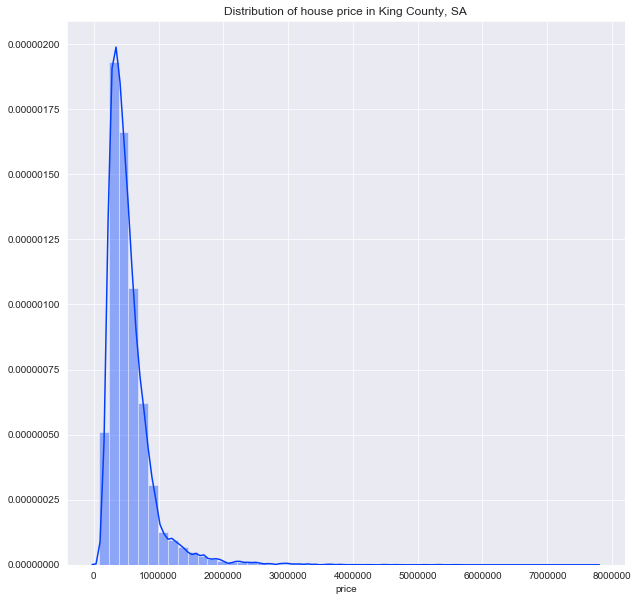

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Distribution of house price in King County, SA')
sns.distplot(df['price'], ax = ax)

In [10]:
df.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


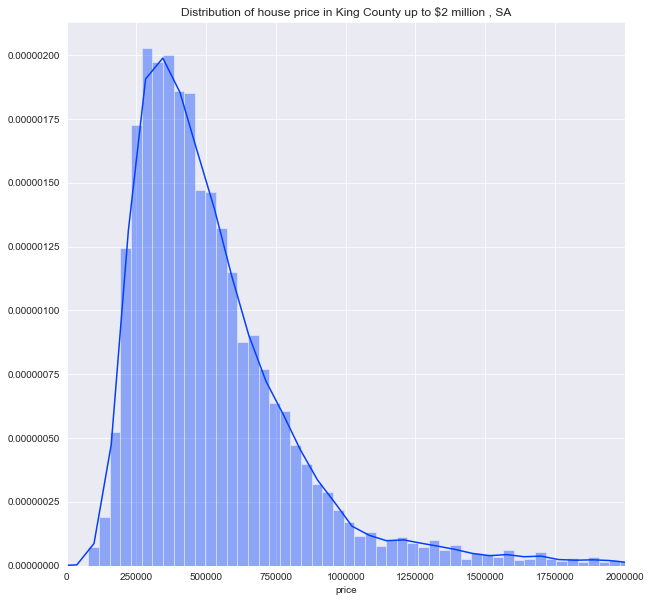

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(0,2000000)
ax.set_title('Distribution of house price in King County up to $2 million , SA')

sns.distplot(df['price'], ax = ax, bins = 200)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


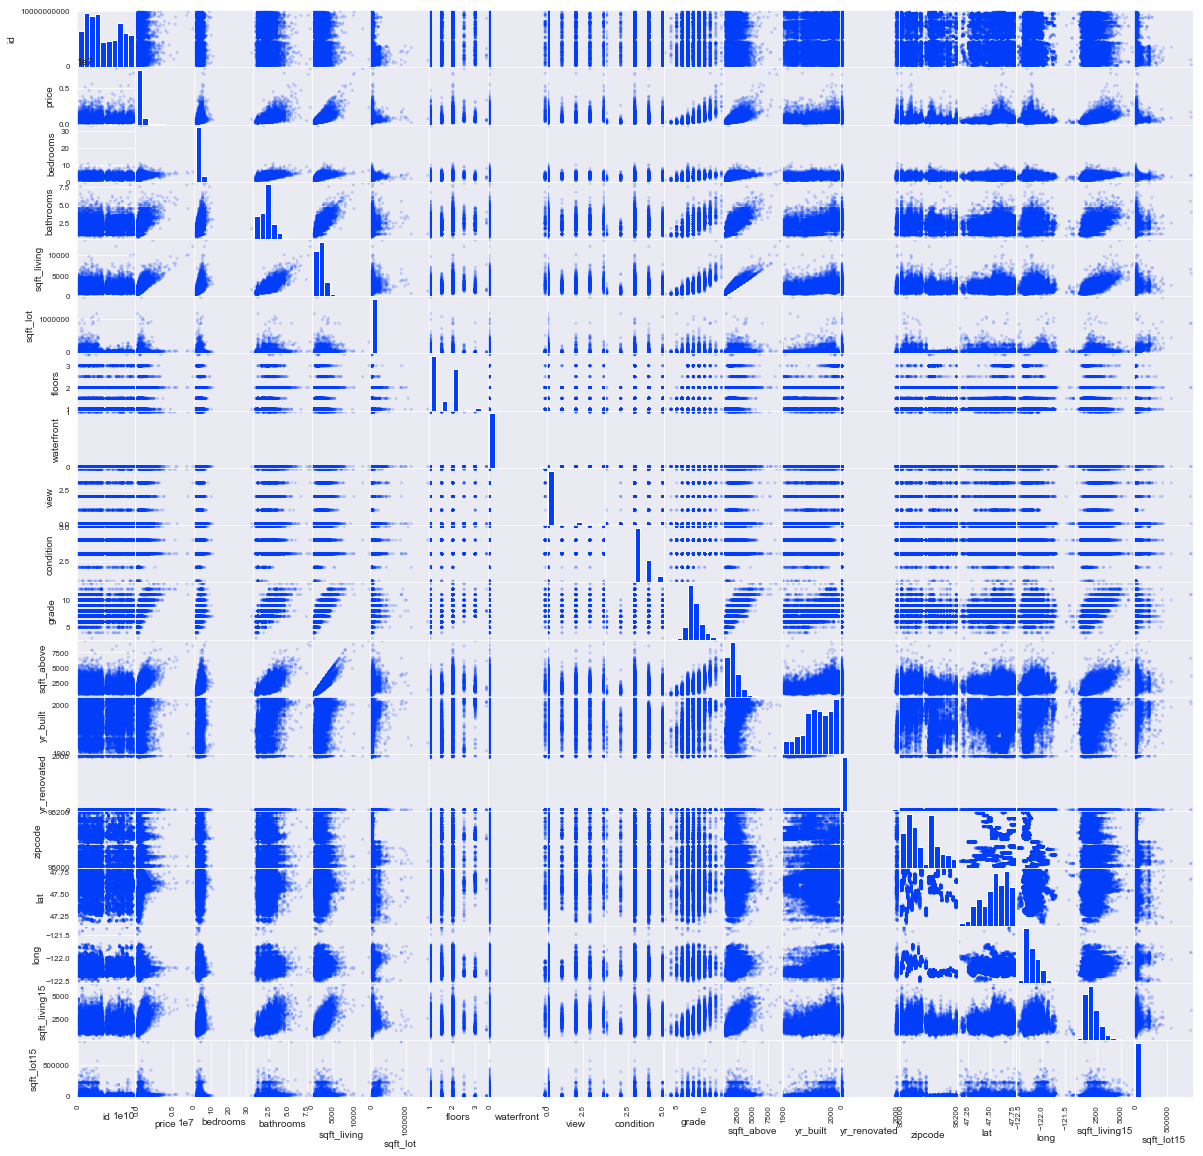

In [12]:
# Checking for obvious correlations, skewed data and categorical data (or lack thereof)

ax.set_title("Scatter matrix of all data variables")
pd.scatter_matrix(df, alpha = 0.2, figsize = (20,20))
plt.show()

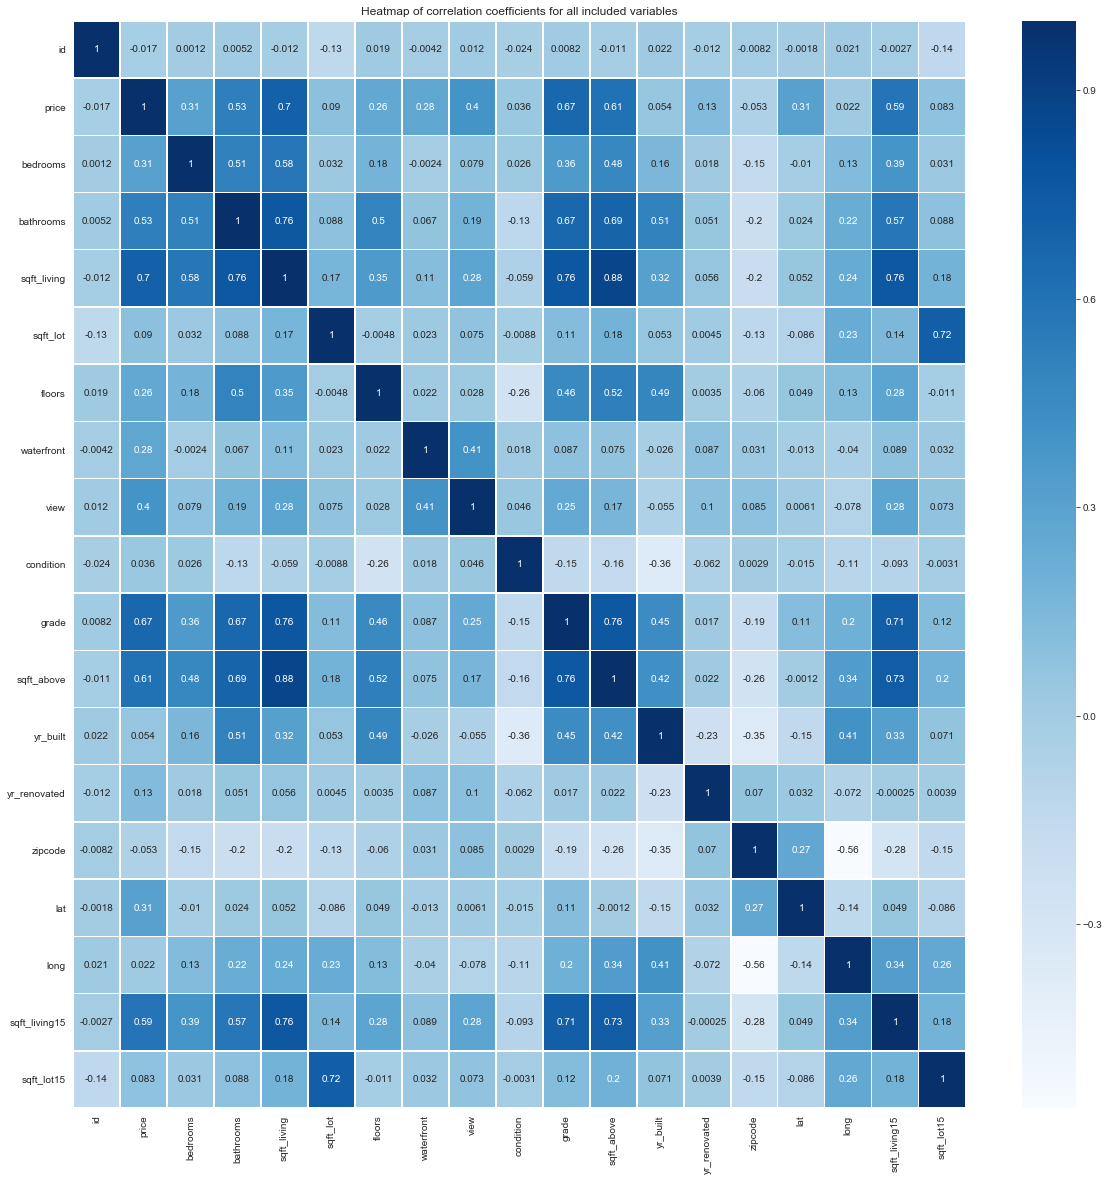

In [13]:
fig, ax =  plt.subplots(figsize = (20,20))
ax.set_title('Heatmap of correlation coefficients for all included variables')
matrix = df.corr()
sns.heatmap(matrix, annot = True, linewidths = 0.4, ax = ax, cmap = 'Blues')

To give us a bird's eye overview of the data, we plotted a scatter matrix, paying particular attention to anything that correlated with price and a heatmap to find the highest coefficients our heatmap showed that grade, sqft_living and location were the optimal non-multicollinear variables. 

Since we couldn't clearly define grade and internet research threw up several interpretations of 'grade' (including bulding code, building quality and slope gradient) we decided to exclude grade from our further analysis.

<a id='Data-Cleaning'></a>

## 2. Data Cleaning 


In [14]:
df['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [15]:
df['yr_built'].describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

In [16]:

df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Here we were checking for null values we found 3 variables that might need cleaning. However we discarded View because there were so few houses with a view (in cell below: view=0.0 has a count of 19422) and it doesn't seem like a scalable variable that our client could use. The same problem applies to the waterfront values (n=146).

In [17]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [18]:
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [19]:
df.isna().sum() # lots of yr_renovated null values. 

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [20]:
df['yr_renovated'].value_counts().head() # also a lot of hidden null values, so we decided to explore more

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Further exploration of other variables. 

In [21]:
df['bathrooms'].value_counts()

2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
5.25      13
5.50      10
1.25       9
6.00       6
5.75       4
0.50       4
8.00       2
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [22]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [23]:
df.loc[df['bedrooms'] == 33]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
15856      6000     1.0         0.0   0.0     ...          7        1040   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0     1947           0.0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

In [24]:
df.loc[df['bathrooms'] == 7.75] # exploring outliers in the data. 

id       date      price  bedrooms  bathrooms  sqft_living  \
9245  9208900037  9/19/2014  6890000.0         6       7.75         9890   

      sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
9245     31374     2.0         0.0   4.0     ...         13        8860   

      sqft_basement yr_built  yr_renovated  zipcode      lat    long  \
9245         1030.0     2001           0.0    98039  47.6305 -122.24   

      sqft_living15  sqft_lot15  
9245           4540       42730  

[1 rows x 21 columns]

In [25]:
df.loc[df['yr_renovated'] != 0].head()

id       date     price  bedrooms  bathrooms  sqft_living  \
1   6414100192  12/9/2014  538000.0         3       2.25         2570   
2   5631500400  2/25/2015  180000.0         2       1.00          770   
12   114101516  5/28/2014  310000.0         3       1.00         1430   
23  8091400200  5/16/2014  252700.0         2       1.50         1070   
26  1794500383  6/26/2014  937000.0         3       1.75         2450   

    sqft_lot  floors  waterfront  view     ...      grade  sqft_above  \
1       7242     2.0         0.0   0.0     ...          7        2170   
2      10000     1.0         0.0   0.0     ...          6         770   
12     19901     1.5         0.0   0.0     ...          7        1430   
23      9643     1.0         NaN   0.0     ...          7        1070   
26      2691     2.0         0.0   0.0     ...          8        1750   

    sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
1           400.0     1951        1991.0    98125  47.7210 -122.319   
2             0.0     1933           NaN    98028  47.7379 -122.233   
12            0.0     1927           NaN    98028  47.7558 -122.229   
23            0.0     1985           NaN    98030  47.3533 -122.166   
26          700.0     1915           NaN    98119  47.6386 -122.360   

    sqft_living15  sqft_lot15  
1            1690        7639  
2            2720        8062  
12           1780       12697  
23           1220        8386  
26           1760        3573  

[5 rows x 21 columns]

At this stage we decided to export our data to another dedicated Jupyter notebook ("Data Cleaning") and then reimport the clean dataframe. Below is a summary of how we modified the data:

We added a new column for whether a house has been renovated or not. If there is a null value or zero for year of renovation, we've set it zero. We inspect the NaN values in yr_renovated and checked the measures of dispersion on yr_built to check our houses that had null values before deciding to either drop them or mark them as not renovated.
We've decided to replace Nan values with not renovated on the assumption that renovation would have been advertized otherwise when trying to sell the house. We therefore added a column for "year last updated" - houses with value zero for renovation will have their yr_built value used instead. 
We added a column that computed price per square foot, the distance to the highes priced property and the distance to the property with the highest price per square foot. 

In [26]:
clean_df = pd.read_csv('cleaned_data.csv')

In [27]:
clean_df = clean_df.drop(columns = 'Unnamed: 0')
clean_df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view            ...                  lat  \
0      5650     1.0         NaN   0.0            ...              47.5112   
1      7242     2.0         0.0   0.0            ...              47.7210   
2     10000     1.0         0.0   0.0            ...              47.7379   
3      5000     1.0         0.0   0.0            ...              47.5208   
4      8080     1.0         0.0   0.0            ...              47.6168   

      long  sqft_living15 sqft_lot15  datetime_date  renovated  \
0 -122.257           1340       5650     2014-10-13          0   
1 -122.319           1690       7639     2014-12-09          1   
2 -122.233           2720       8062     2015-02-25          0   
3 -122.393           1360       5000     2014-12-09          0   
4 -122.045           1800       7503     2015-02-18          0   

   yr_last_updated  price_per_sqft  dist_highest_price_prop  \
0           1955.0      188.050847                 0.135728   
1           1991.0      209.338521                 0.091288   
2           1933.0      233.766234                 0.140661   
3           1965.0      308.163265                 0.129541   
4           1987.0      303.571429                 0.278304   

   dist_highest_pricepersqft  
0                   0.221226  
1                   0.074650  
2                   0.161218  
3                   0.169506  
4                   0.349788  

[5 rows x 27 columns]

<a id='Further-Exploration-and-Visualization'></a>

## 3. Further exploration and visualization 


In [28]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 27 columns):
id                           21597 non-null int64
date                         21597 non-null object
price                        21597 non-null float64
bedrooms                     21597 non-null int64
bathrooms                    21597 non-null float64
sqft_living                  21597 non-null int64
sqft_lot                     21597 non-null int64
floors                       21597 non-null float64
waterfront                   19221 non-null float64
view                         21534 non-null float64
condition                    21597 non-null int64
grade                        21597 non-null int64
sqft_above                   21597 non-null int64
sqft_basement                21597 non-null object
yr_built                     21597 non-null int64
yr_renovated                 17755 non-null float64
zipcode                      21597 non-null int64
lat                        

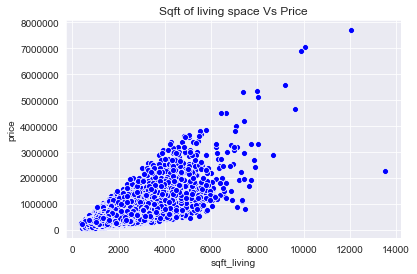

In [29]:
ax = plt.gca()
ax.set_title("Sqft of living space Vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=clean_df['sqft_living'], y = clean_df['price'], color = 'blue', ax = ax)


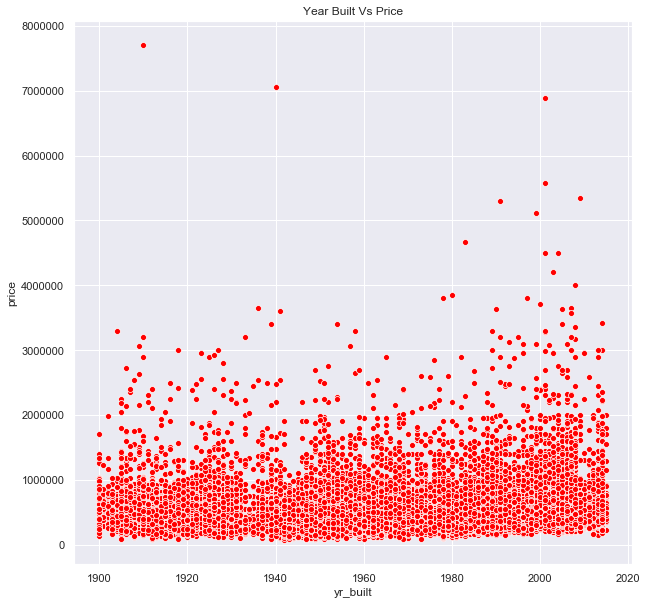

In [30]:
ax = plt.gca()
ax.set_title("Year Built Vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=clean_df['yr_built'], y = clean_df['price'], color = 'red', ax = ax)


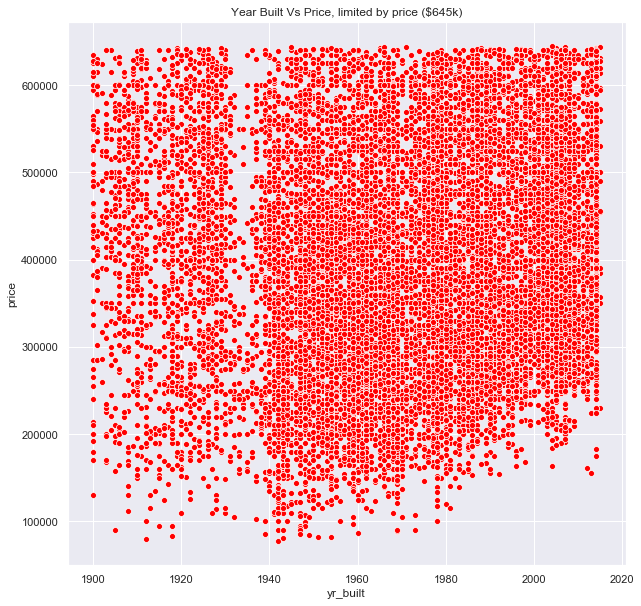

In [31]:
ax = plt.gca()
ax.set_title("Year Built Vs Price, limited by price ($645k)")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x=clean_df.loc[df.price < 645000]['yr_built'], y = clean_df.loc[df.price < 645000]['price'], color = 'red')

After attempting to plot with the full data for prices and yr_built we have replotted with outliers removed.
However, this did not help to reveal any meaningful patterns. Using our updated list from the clean df ('yr_last_updated') we've found a potentially more meaningful pattern. However, following regression analysis the age of update doesn't seem to dictate the price. 

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


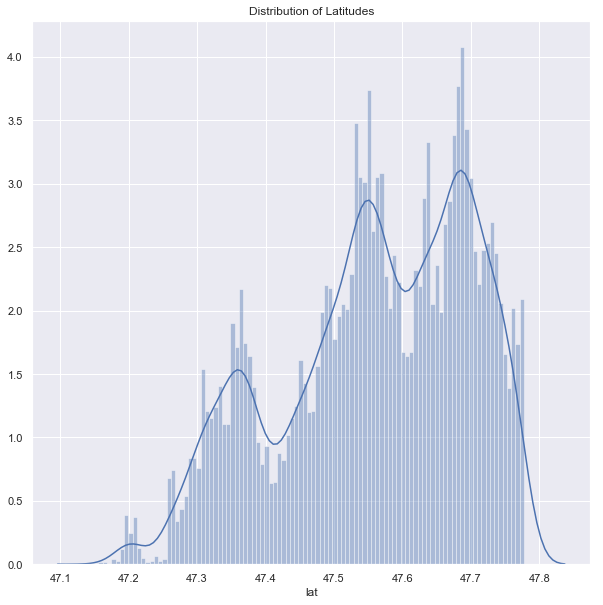

In [32]:
ax = plt.gca()
ax.set_title("Distribution of Latitudes")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(clean_df.lat,bins=100)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


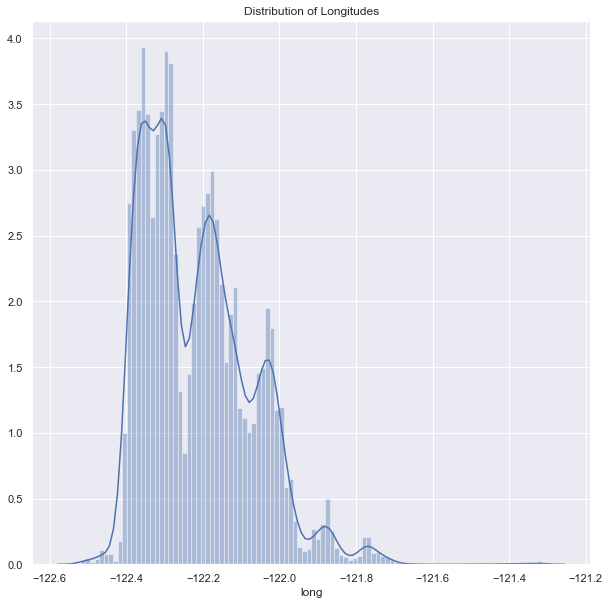

In [33]:
ax = plt.gca()
ax.set_title("Distribution of Longitudes")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(clean_df.long, bins=100)

Looking at our distribution for latitude, we can see that the number of house sales in our data are skewed towards
the North of King County, Seattle. Also the distribution of houses along longitudinal lines conforms to our 
expectations, given that Seattle is in the West of the county. 

Below we also plotted a scatter of the latitudeversus the price, given that the correlation between the two is 0.31. 

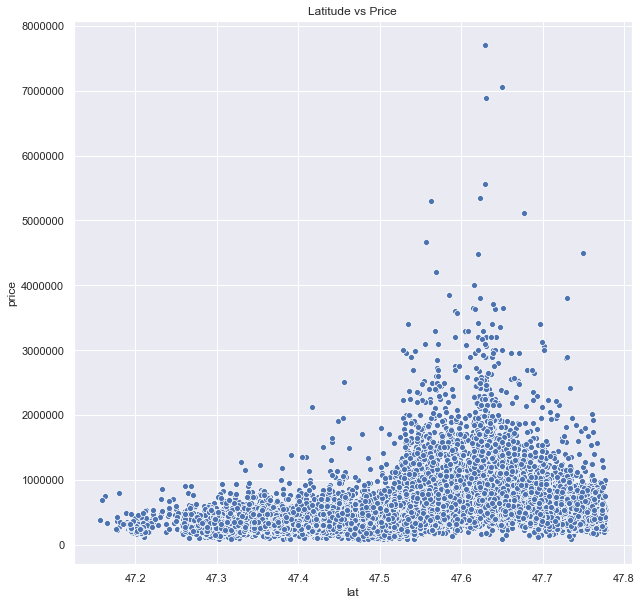

In [34]:
ax = plt.gca()
ax.set_title("Latitude vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x = clean_df.lat, y = clean_df.price)

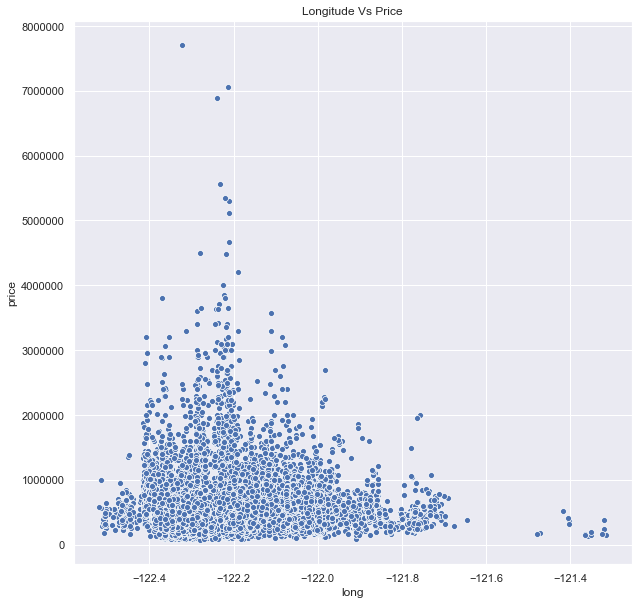

In [35]:
ax = plt.gca()
ax.set_title("Longitude Vs Price")
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x = df.long, y = df.price)

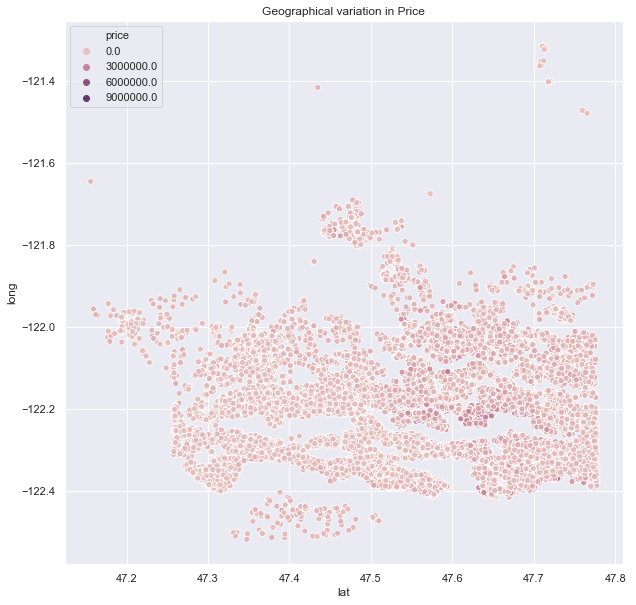

In [54]:
ax = plt.gca()
ax.set_title("Geographical variation in Price")
sns.set(rc={'figure.figsize':(10,10)})
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=df.lat, y=df.long, hue=df.price, palette=cmap)

We wanted to explore the question of high prices being distributed around a central point. We investigated by choosing a famous landmark of Seattle, The Space Needle.

We found some correlation between prices and distance to the Space Needle, however a stronger correlation was found by pinpointing the most expensive property (absolute and price/square foot) and calculating the straight line distance from this.

In [55]:
needle_lat = 47.620422
needle_long = -122.349358
clean_df['dist_from_needle'] = np.sqrt((clean_df.long - needle_long)**2 + (clean_df.lat - needle_lat)**2)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


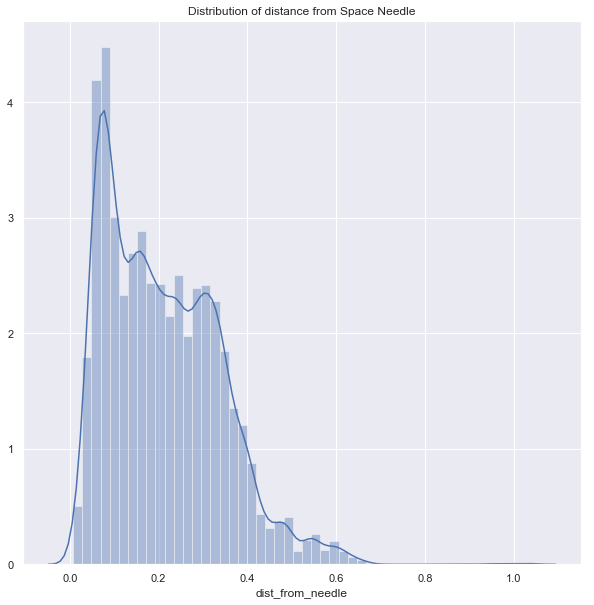

In [56]:
ax = plt.gca()
ax.set_title("Distribution of distance from Space Needle")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(clean_df.dist_from_needle)

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


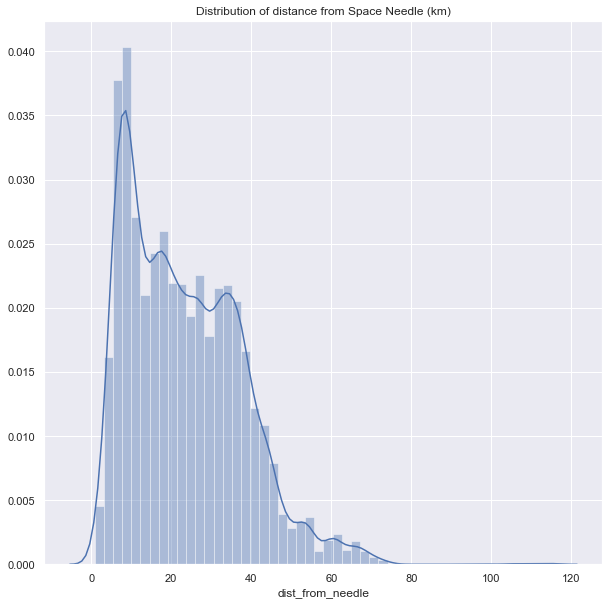

In [57]:
ax = plt.gca()
ax.set_title("Distribution of distance from Space Needle (km)")
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(111*clean_df.dist_from_needle) # Converting distance from degrees to KM

In [58]:
round((clean_df.dist_from_needle.describe()) * 111,2)

count    2397267.00
mean          23.36
std           14.34
min            0.82
25%           10.85
50%           21.34
75%           33.50
max          115.27
Name: dist_from_needle, dtype: float64

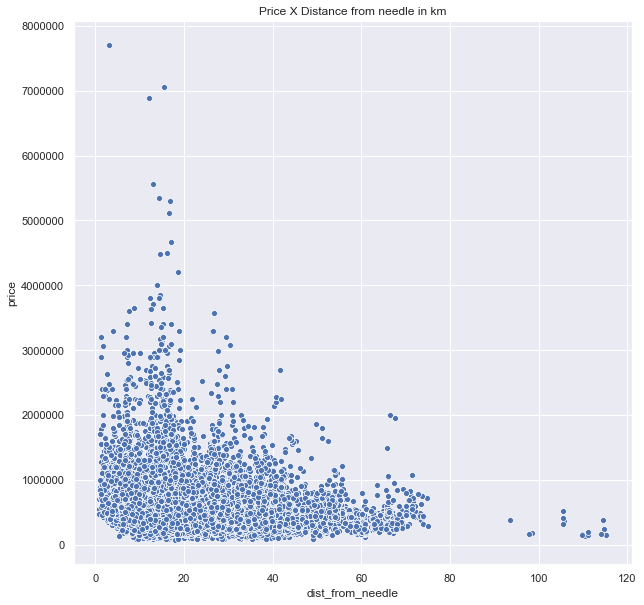

In [59]:
ax = plt.gca()
ax.set_title("Price X Distance from needle in km")
sns.scatterplot(x=111*clean_df.dist_from_needle, y = clean_df.price)

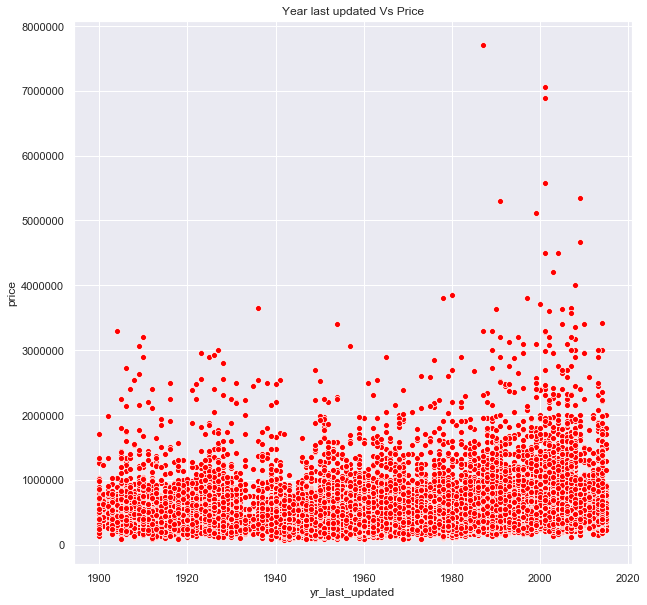

In [60]:
ax = plt.gca()
ax.set_title("Year last updated Vs Price")

sns.scatterplot(x=clean_df['yr_last_updated'], y = clean_df['price'], color = 'red')

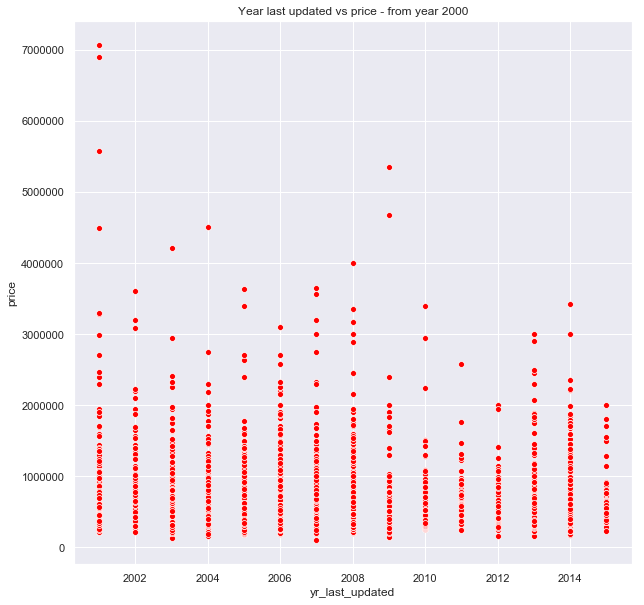

In [61]:
ax = plt.gca()
ax.set_title("Year last updated vs price - from year 2000")

sns.scatterplot(x=clean_df.loc[( (clean_df.yr_last_updated > 2000))]['yr_last_updated'], y = df.loc[((clean_df.yr_last_updated > 2000))]['price'], color = 'red')

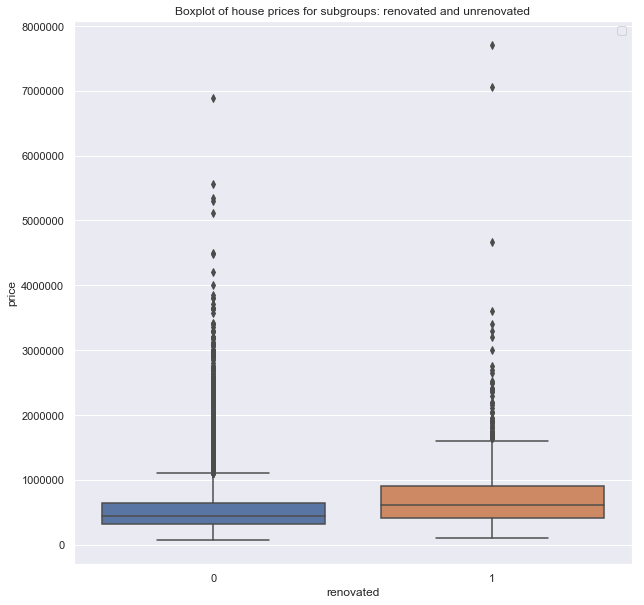

In [62]:
# We've subcatgorized the houses by renovation and showed the different attributes for the two subgroups
ax = plt.gca()
ax.set_title("Boxplot of house prices for subgroups: renovated and unrenovated")
ax.legend(labels=['Not renovated','Renovated'])
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x = clean_df['renovated'], y = clean_df['price'])

(0, 2000000)

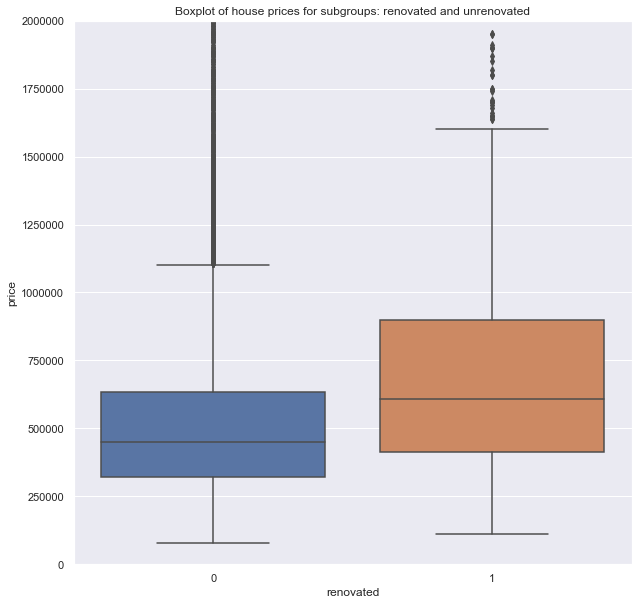

In [63]:
# zoomed in to remove outliers
ax = plt.gca()
ax.set_title("Boxplot of house prices for subgroups: renovated and unrenovated")
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x = clean_df['renovated'], y = clean_df['price'])

plt.ylim([0,2000000])


<a id='Model-construction:'></a>

## 4. Model construction:


<a id='Splitting-our-data'></a>

### 4.1 Splitting into training and validation data

We're taking our data and training our statsmodels linear regression on 80% of our data (marked as "train_df") and then testing it in section 4.3 on our validation data (test_df). We'll also be checking for the normality and similarity of our split data sets before using them. 

In [64]:
len(clean_df)

21597

In [65]:
test_df = clean_df.iloc[(int(len(clean_df)/5)*4) : len(clean_df)]
len(test_df)

4321

In [66]:
train_df = clean_df.iloc[0:int(len(clean_df)/5)*4]
len(train_df)

17276

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


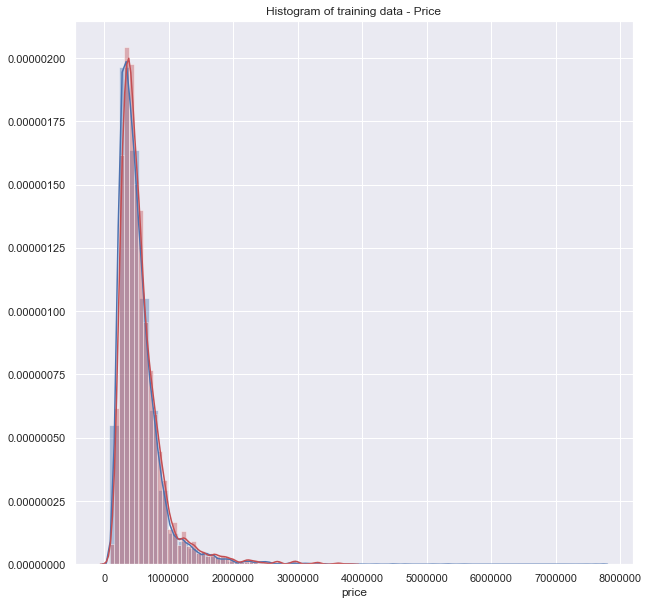

In [67]:
ax = plt.gca()
ax.set_title("Histogram of training data - Price")
sns.set(rc={'figure.figsize':(20,20)})
sns.distplot(train_df['price'],color='b')
sns.distplot(test_df['price'],color='r')

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


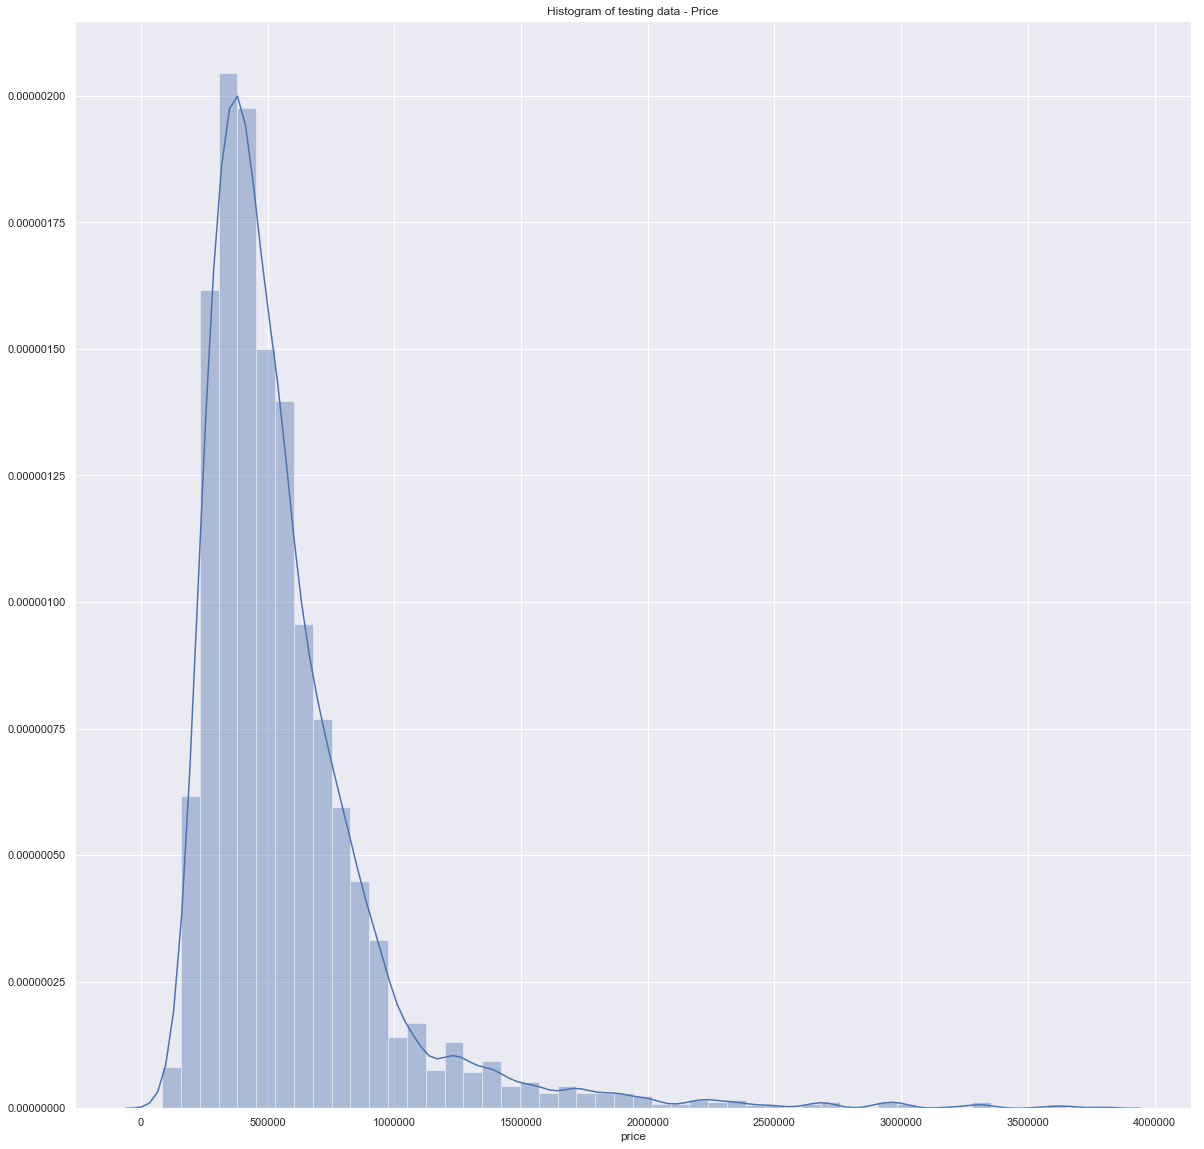

In [68]:
ax = plt.gca()
ax.set_title("Histogram of testing data - Price")
sns.set(rc={'figure.figsize':(20,20)})
sns.distplot(test_df['price'])

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


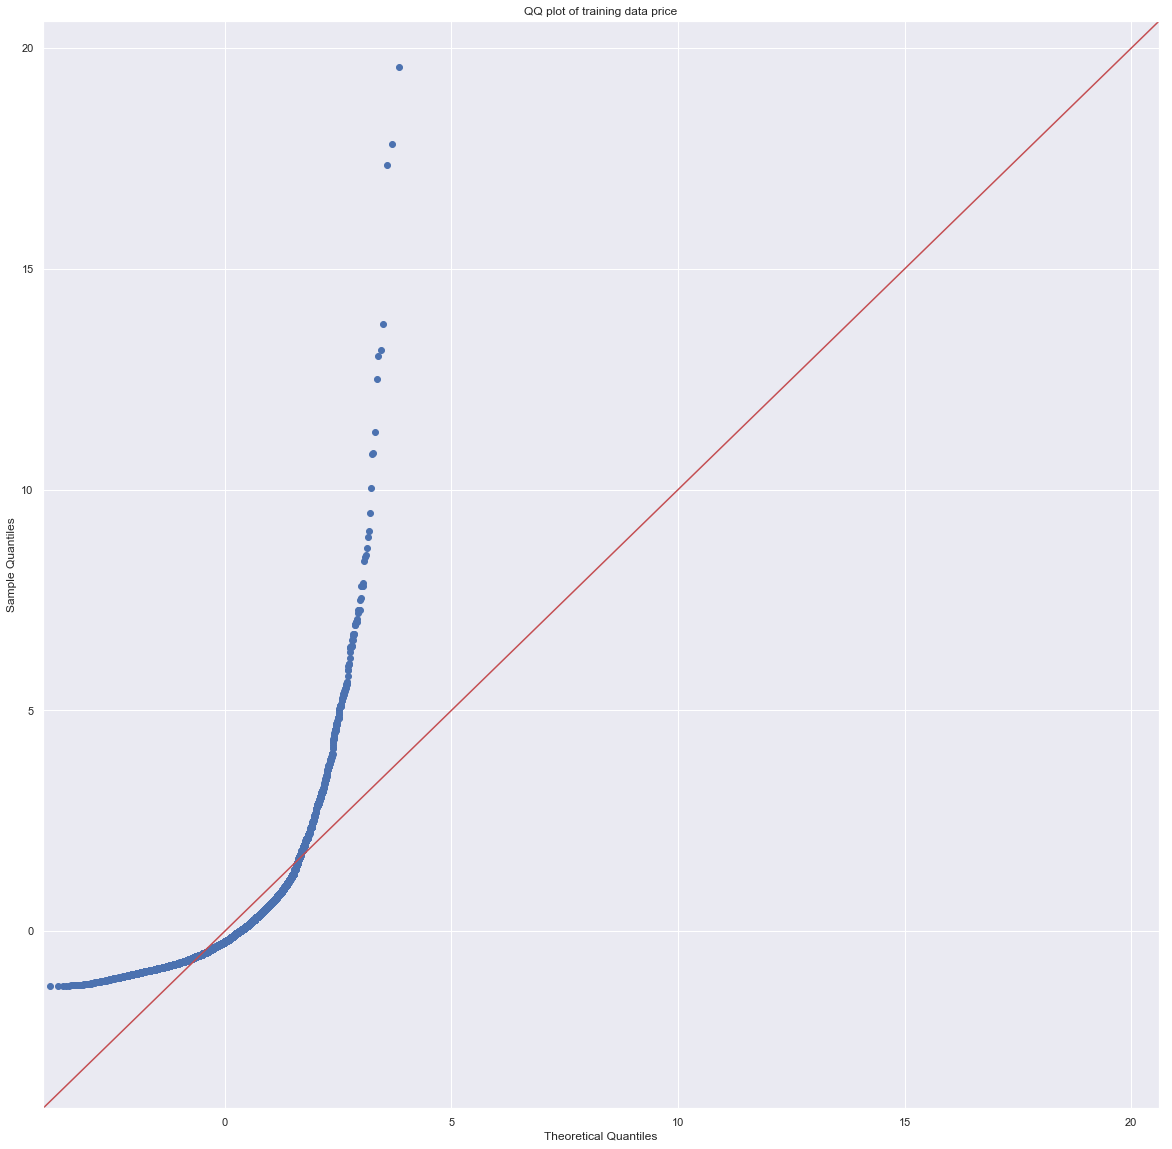

In [69]:
ax = plt.gca()
ax.set_title("QQ plot of training data price")
price_data_train = (train_df.price-train_df.price.mean())/train_df.price.std()
fig = sm.graphics.qqplot(price_data_train,dist=stats.norm, line='45', fit=True, ax=ax)
fig.show()

In [70]:
# Upon testing for the data's normality, it becomes self-evident that our data is being very heavily influenced 
# by our outliers. We decide to use the log of price instead. 

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


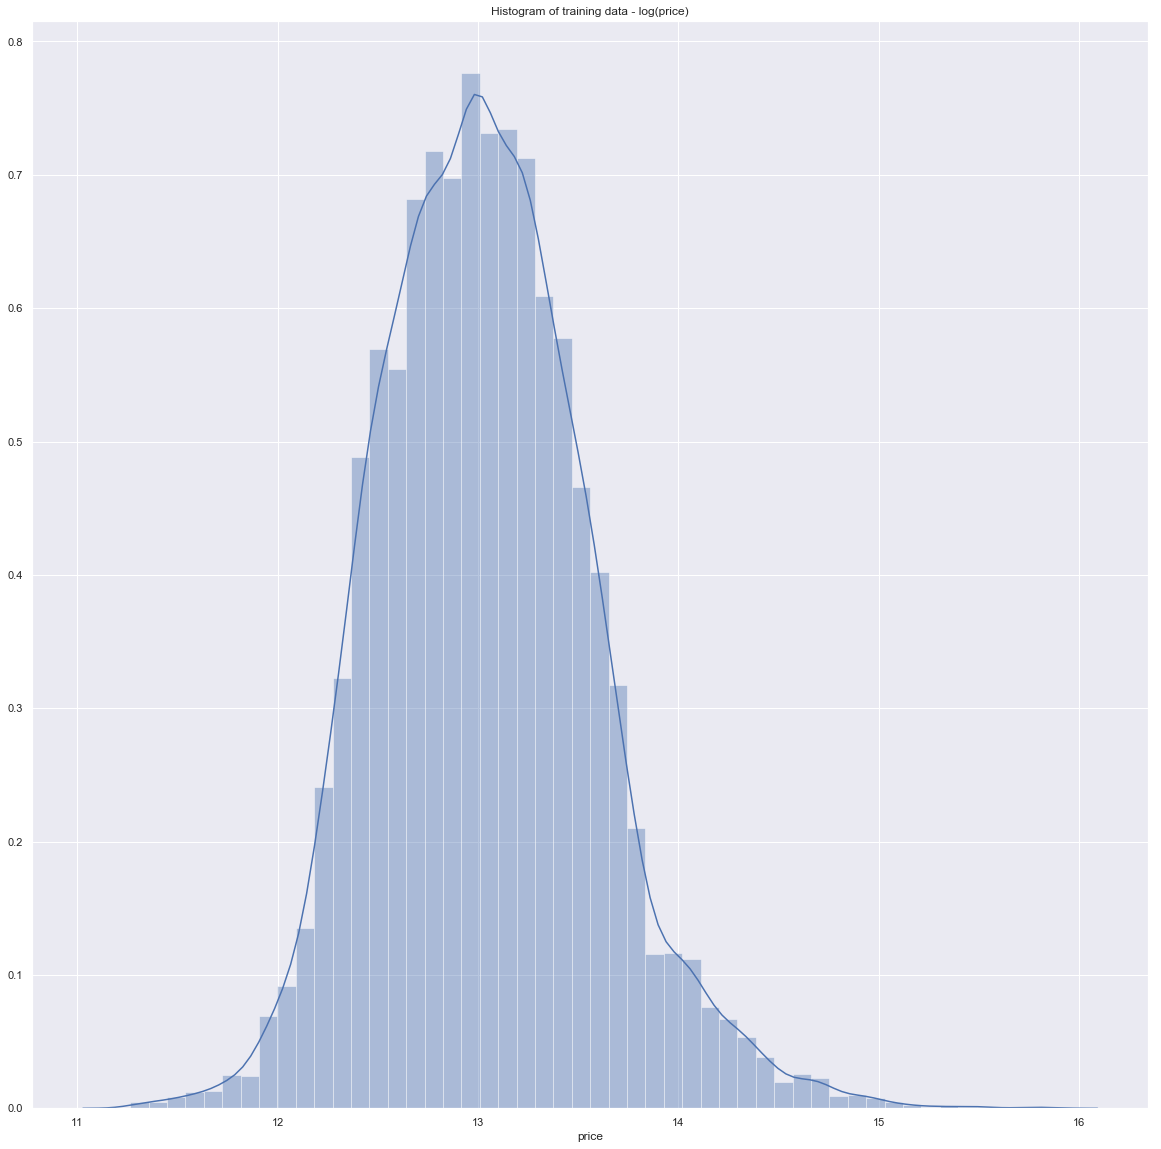

In [71]:
ax = plt.gca()
ax.set(xlabel='log(price)', title='Histogram of training data - log(price)')
sns.distplot(np.log(train_df.price))


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


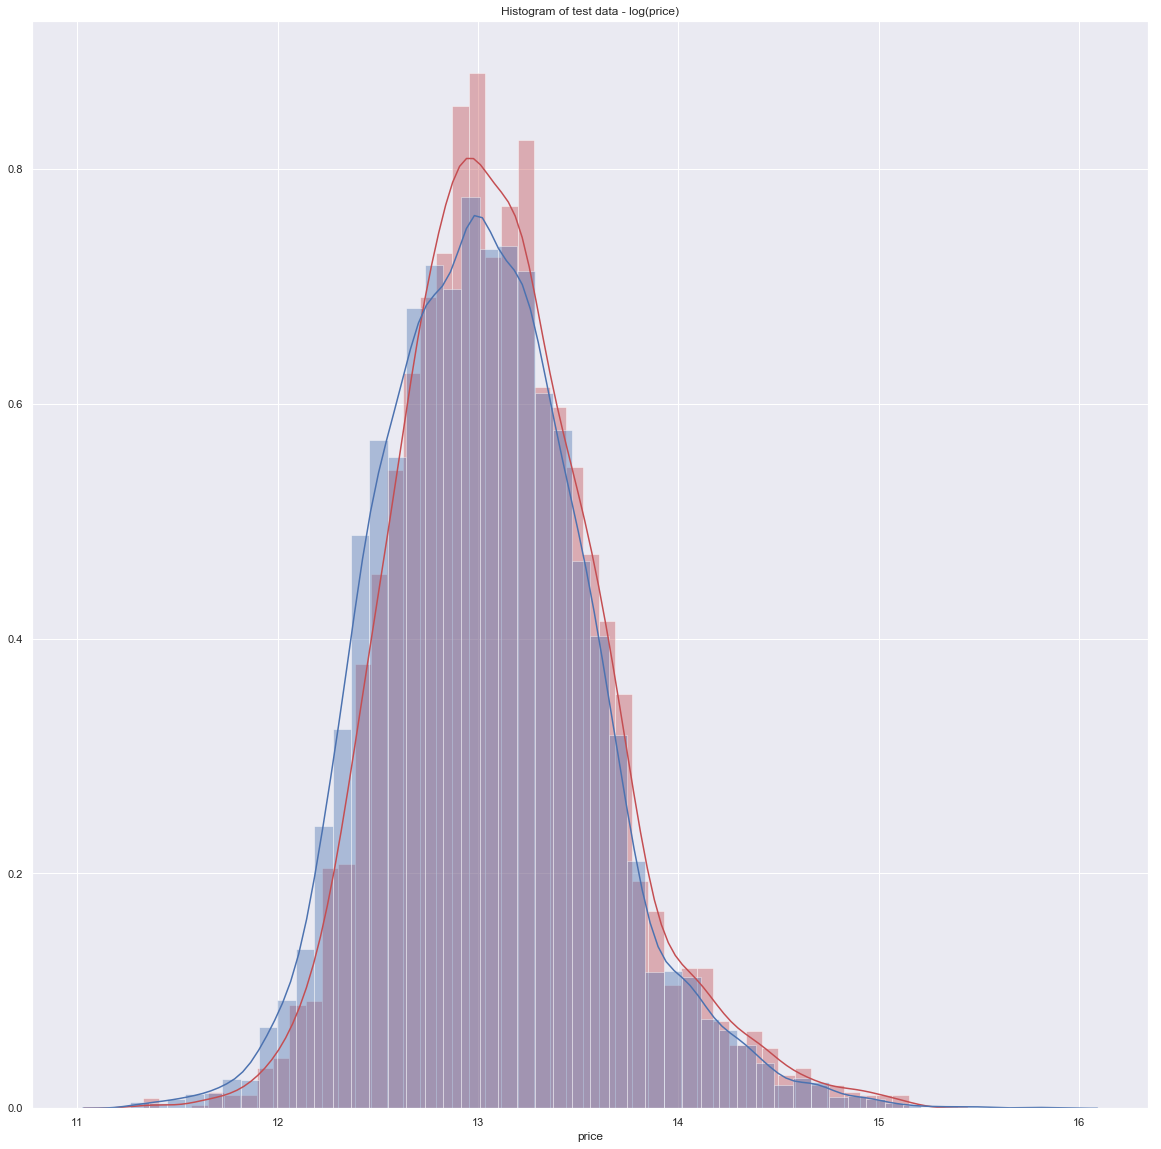

In [72]:
ax = plt.gca()
ax.set(xlabel='log(price)', title='Histogram of test data - log(price)')
sns.distplot(np.log(test_df.price),color='r')
sns.distplot(np.log(train_df.price),color='b')

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


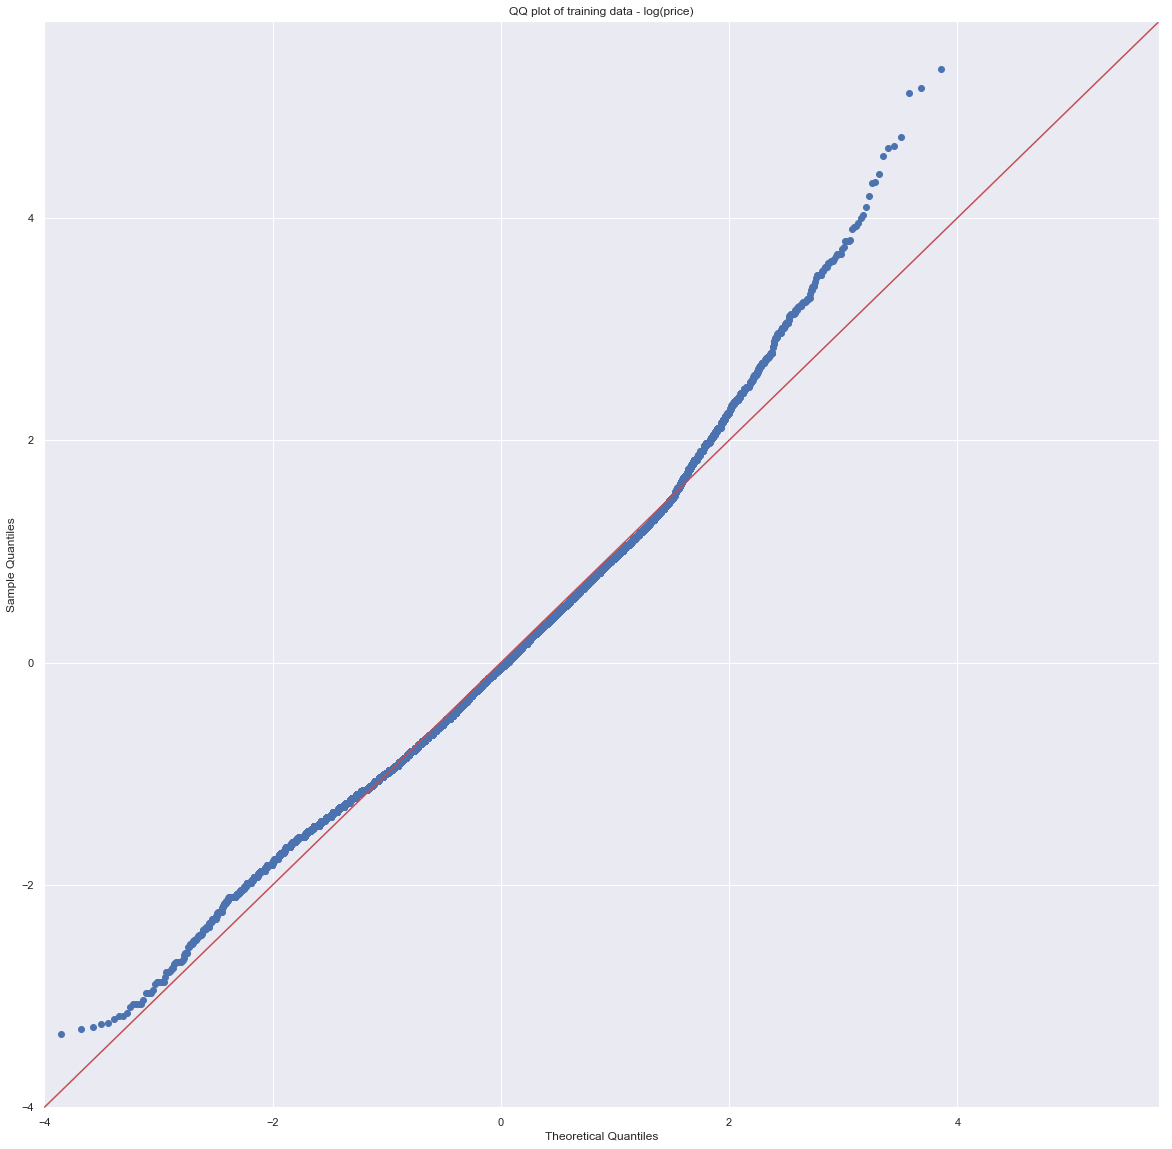

In [73]:
ax = plt.gca()
ax.set( title='QQ plot of training data - log(price)')

price_data_train = (np.log(train_df.price)-np.log(train_df.price).mean())/np.log(train_df.price).std()

fig = sm.graphics.qqplot(price_data_train,dist=stats.norm, line='45', fit=True,ax=ax)
fig.show()


In [74]:
# For the most part of our training and testing data there seemes to be a normal distribution, however model 
# validity could be questioned at higher priced data. Fortunately both the training and testing data are similarly 
# distributed.

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


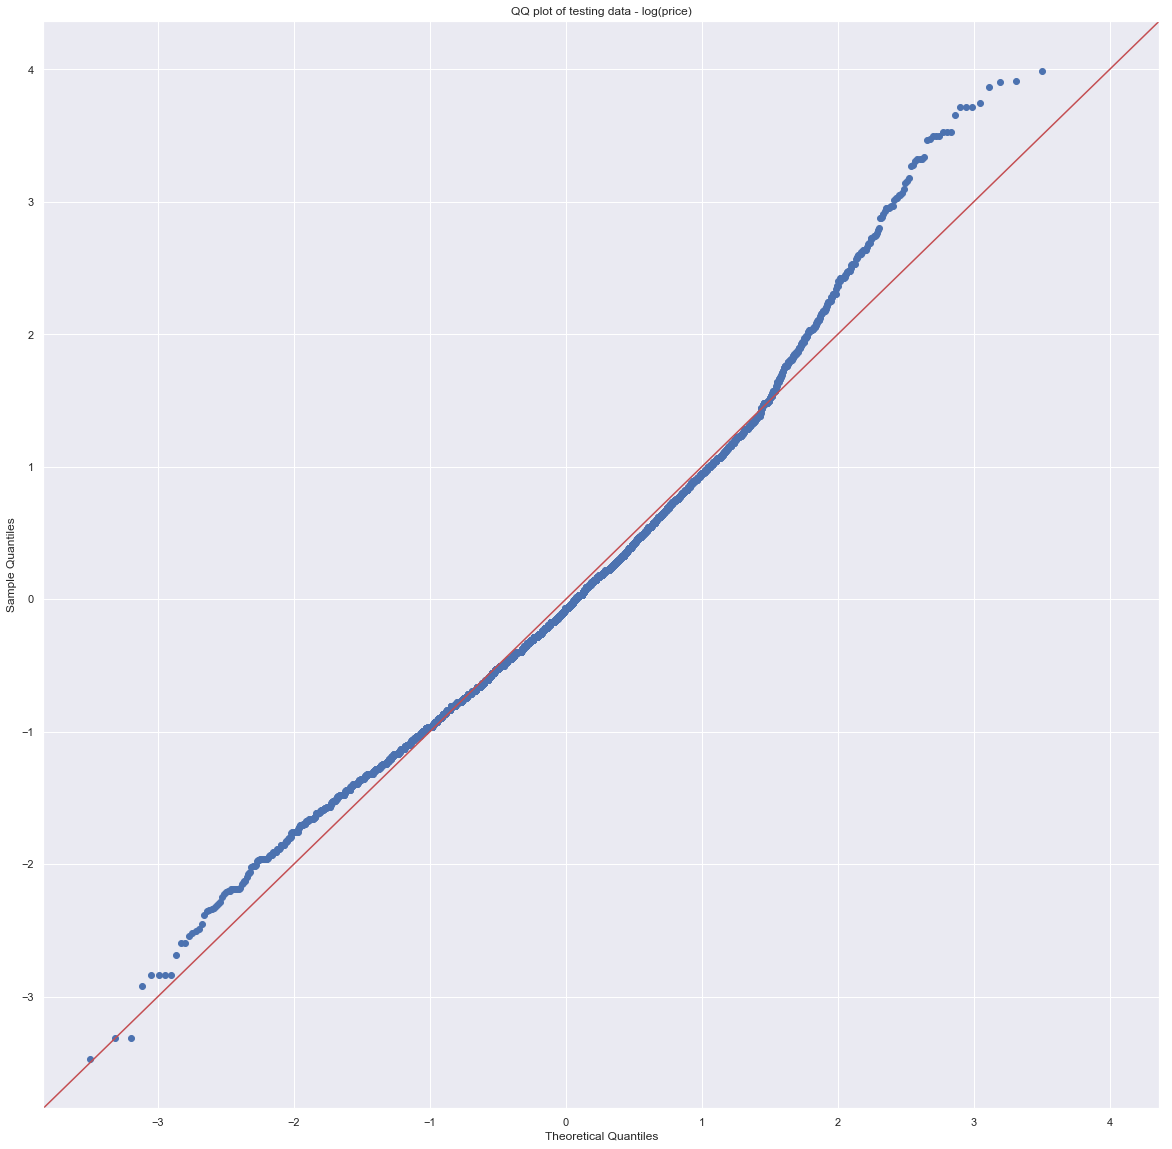

In [75]:
ax = plt.gca()
ax.set( title='QQ plot of testing data - log(price)')

price_data_test = (np.log(test_df.price)-np.log(test_df.price).mean())/np.log(test_df.price).std()
fig = sm.graphics.qqplot(price_data_test,dist=stats.norm, line='45', fit=True,ax=ax)
fig.show()

In [76]:
# given the usefulness of using the log(price), we've modified the clean_df to have a log of price additionally 
# and split the data again. 
# The log(price) represents the marginal increase in price.

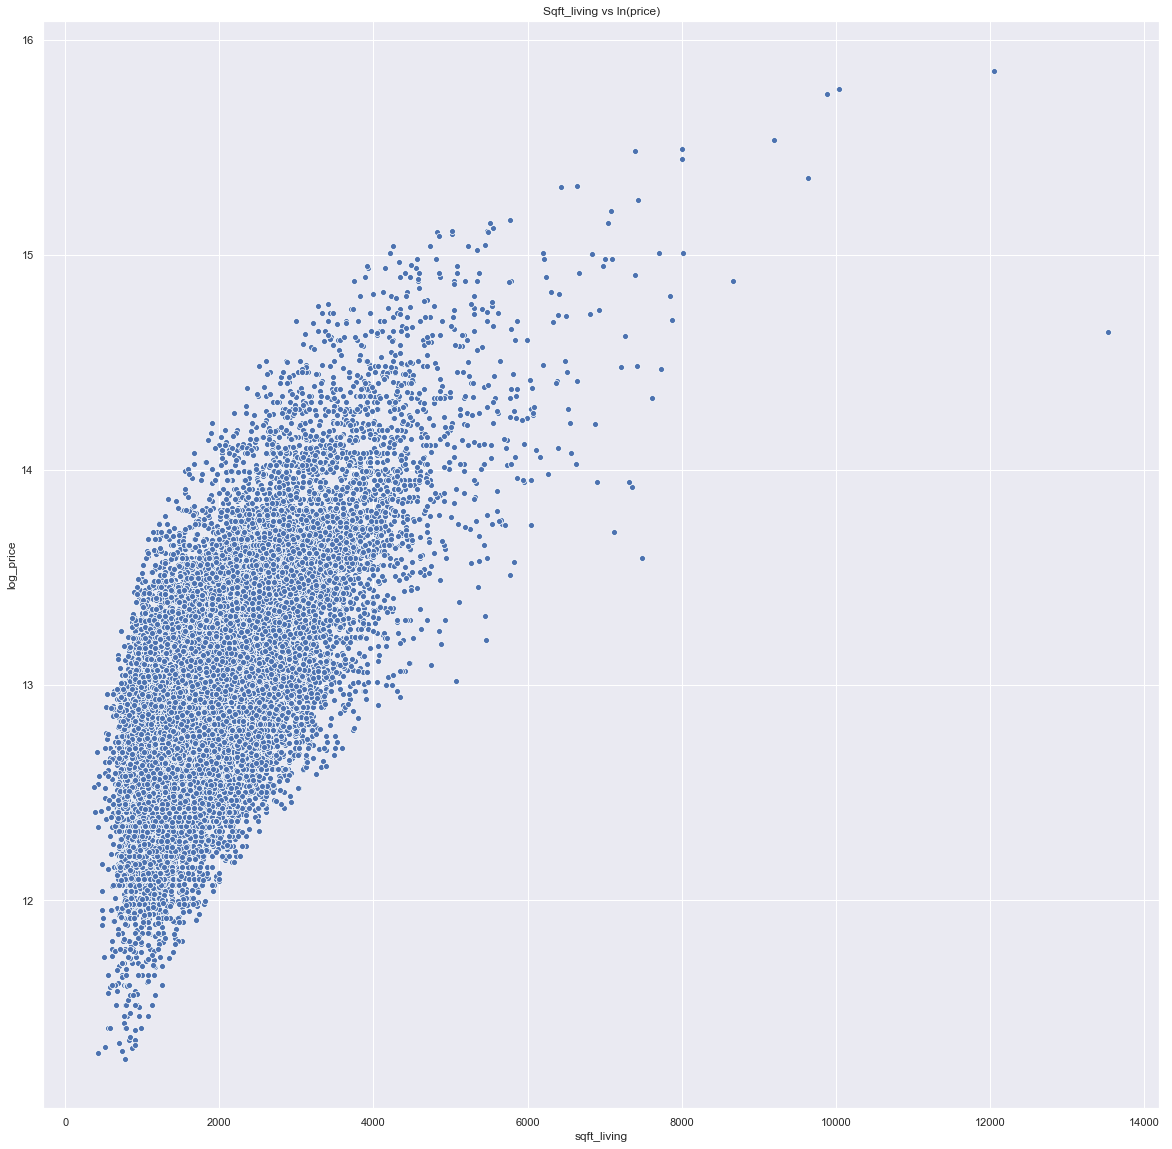

In [143]:
clean_df['log_price'] = np.log(clean_df.price)

fig, ax1 = plt.subplots(figsize = (20,20))
ax1.set_title(label='Sqft_living vs ln(price)')
# To illustrate the difference, we've plotted below the log(price) vs sqft_living
sns.scatterplot(x = clean_df['sqft_living'], y =clean_df['log_price'], ax=ax1)


In [102]:

train_df = clean_df.iloc[0:int(len(clean_df)/5)*4]
test_df = clean_df.iloc[int(len(clean_df)/5)*4 : len(clean_df)]

test_df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
17276  1974300020  8/27/2014  380000.0         4       2.50         2270   
17277  1974300020  2/18/2015  624900.0         4       2.50         2270   
17278  3630020380  11/7/2014  379770.0         3       2.50         1470   
17279  1771000290  12/3/2014  340000.0         3       1.75         1280   
17280  5126310470  1/15/2015  515500.0         4       2.75         2830   

       sqft_lot  floors  waterfront  view    ...      sqft_living15  \
17276     11500     1.0         0.0   0.0    ...               2020   
17277     11500     1.0         0.0   0.0    ...               2020   
17278      1779     2.0         0.0   0.0    ...               1470   
17279     16200     1.0         0.0   0.0    ...               1160   
17280      8126     2.0         0.0   0.0    ...               2830   

       sqft_lot15  datetime_date renovated  yr_last_updated  price_per_sqft  \
17276       10918     2014-08-27         0           1967.0      167.400881   
17277       10918     2015-02-18         0           1967.0      275.286344   
17278        1576     2014-11-07         0           2005.0      258.346939   
17279       10565     2014-12-03         0           1976.0      265.625000   
17280        7916     2015-01-15         0           2005.0      182.155477   

       dist_highest_price_prop  dist_highest_pricepersqft  dist_from_needle  \
17276                 0.113933                   0.147193          0.139892   
17277                 0.113933                   0.147193          0.139892   
17278                 0.335332                   0.414451          0.358907   
17279                 0.276135                   0.320331          0.304031   
17280                 0.232554                   0.320288          0.248635   

       log_price  
17276  12.847927  
17277  13.345347  
17278  12.847321  
17279  12.736701  
17280  13.152893  

[5 rows x 29 columns]

<a id='Training-our-model'></a>

### 4.2 Training our model


<a id='univariatesqft_living'></a>

In [147]:

# Modelling phase: our 3 predictor variables: sqft_living; dist_highest_pricepersqft; yr_last_updated; sqft_living15
# We iterated through all univariate models with the aforementioned variables. Although sqft_living has a high R^2 
# value, we tested for heteroskedasticity, and realized that our high-price outliers seemed to have much larger 
# variance and affecting our model. We deal with that issue below. 

formula_sqft_living = 'log_price~sqft_living'
model_1 = ols(formula = formula_sqft_living, data = train_df).fit()
model_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                 1.572e+04
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:21:57   Log-Likelihood:                -7924.6
No. Observations:               17276   AIC:                         1.585e+04
Df Residuals:                   17274   BIC:                         1.587e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2040      0.007   1687.374      0.000      12.190      12.218
sqft_living     0.0004   3.22e-06    125.383      0.000       0.000       0.000
==============================================================================
Omnibus:                        1.284   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                1.269
Skew:                           0.020   Prob(JB):                        0.530
Kurtosis:                       3.009   Cond. No.                     5.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

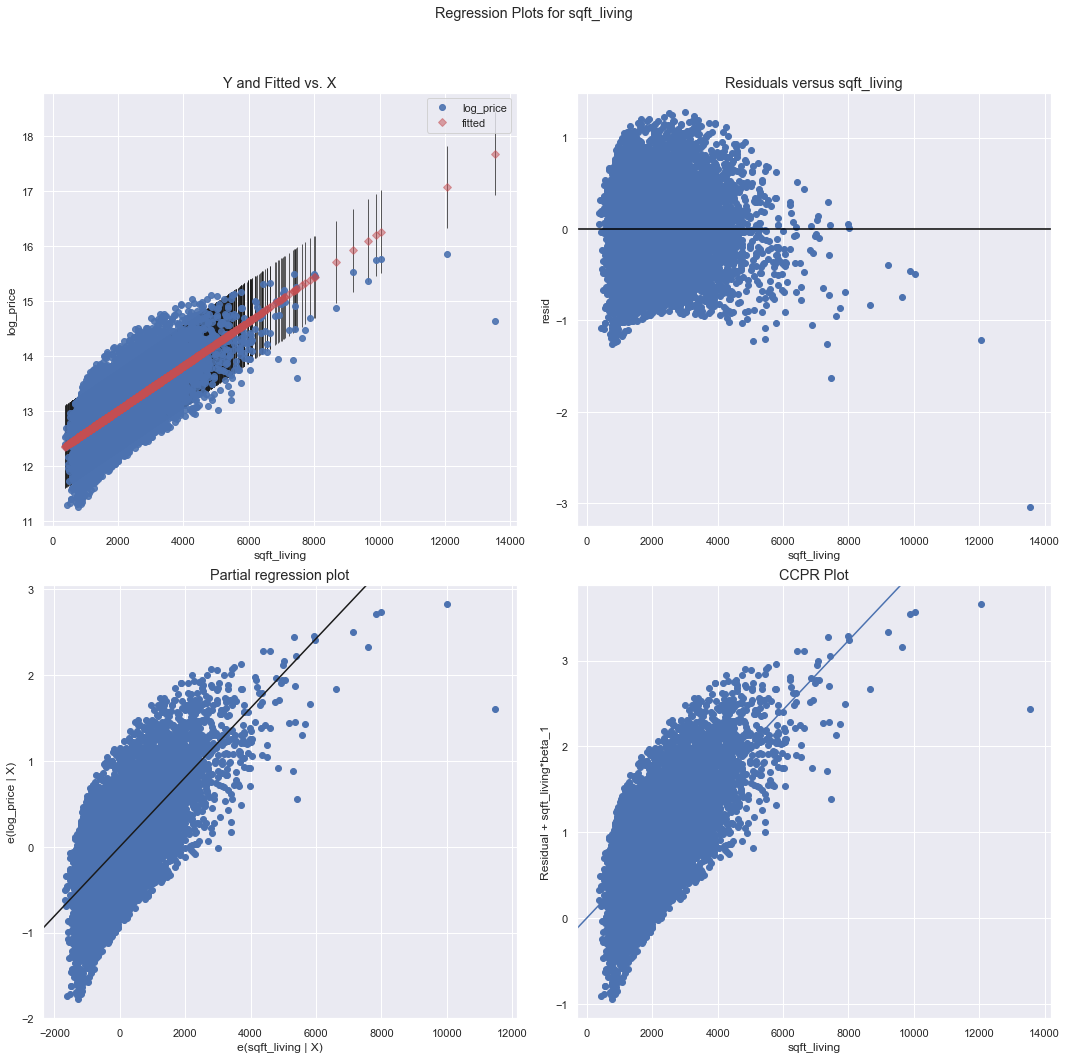

In [104]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(model_1, 'sqft_living',fig=fig)
plt.show()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


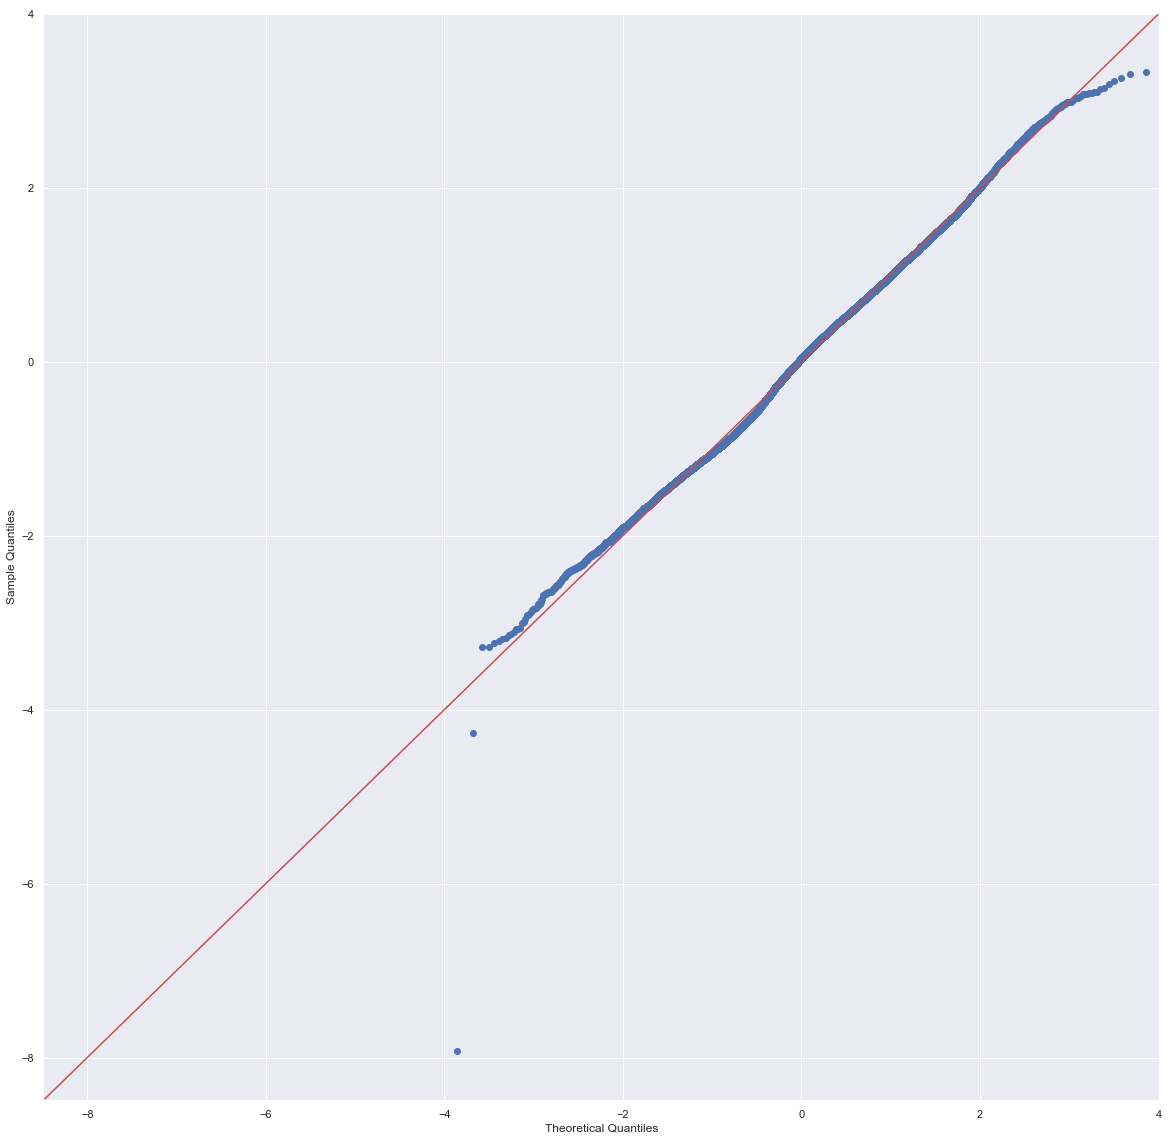

In [105]:
residuals_log_price_sqft_living = model_1.resid
fig = sm.graphics.qqplot(residuals_log_price_sqft_living,dist=stats.norm, line='45', fit=True)
fig.show()

In [106]:
train_df['log_sqft_living'] = np.log(train_df['sqft_living'])

formula_log_price_log_sqft_living = 'log_price~log_sqft_living'
model_1_1 = ols(formula = formula_log_price_log_sqft_living, data = train_df).fit()
model_1_1.summary()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.418e+04
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:21   Log-Likelihood:                -8337.1
No. Observations:               17276   AIC:                         1.668e+04
Df Residuals:                   17274   BIC:                         1.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.6705      0.054    124.639      0.000       6.566       6.775
log_sqft_living     0.8440      0.007    119.090      0.000       0.830       0.858
==============================================================================
Omnibus:                      102.910   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               94.171
Skew:                           0.143   Prob(JB):                     3.56e-21
Kurtosis:                       2.778   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

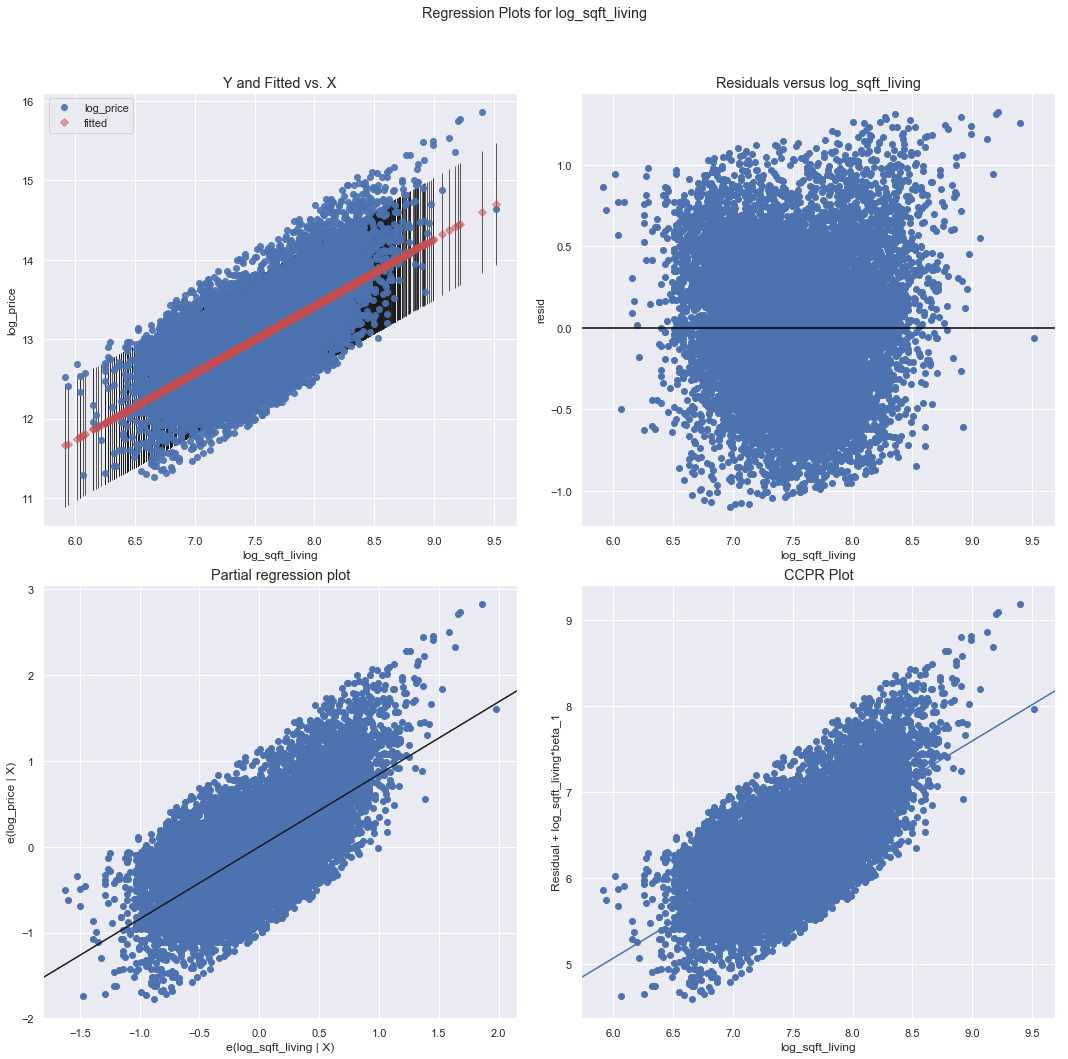

In [107]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(model_1_1, 'log_sqft_living',fig=fig)
plt.show()

In [108]:
# So far we're acquiring improved results with a logarithm of the sqft_living. Our heteroskedasticity has  
# decreased significantly. We're now going to plot the distribution of residuals to confirm the improvement. 

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


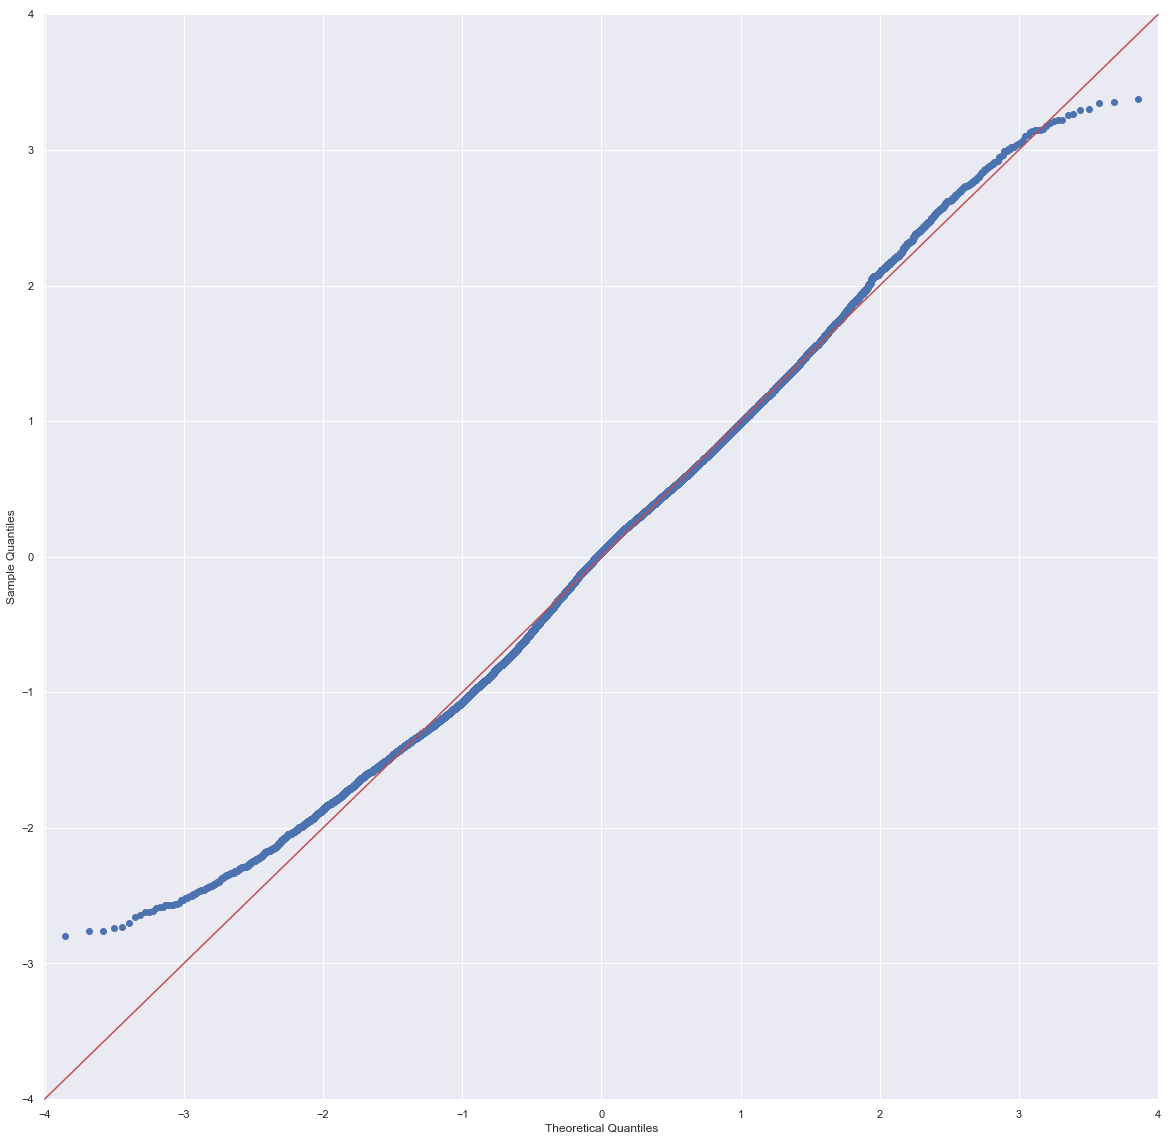

In [109]:
residuals_log_price_log_sqft_living = model_1_1.resid
fig = sm.graphics.qqplot(residuals_log_price_log_sqft_living,dist=stats.norm, line='45', fit=True)
fig.show()

In [110]:
formula_dist_highest_pricepersqft = 'log_price~dist_highest_pricepersqft'
model_2 = ols(formula = formula_dist_highest_pricepersqft, data = train_df).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1473.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):          2.91e-309
Time:                        09:33:24   Log-Likelihood:                -12808.
No. Observations:               17276   AIC:                         2.562e+04
Df Residuals:                   17274   BIC:                         2.564e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    13.2870      0.008   1739.120      0.000      13.272      13.302
dist_highest_pricepersqft    -1.0037      0.026    -38.375      0.000      -1.055      -0.952
==============================================================================
Omnibus:                      813.372   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1062.937
Skew:                           0.476   Prob(JB):                    1.54e-231
Kurtosis:                       3.756   Cond. No.                         7.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

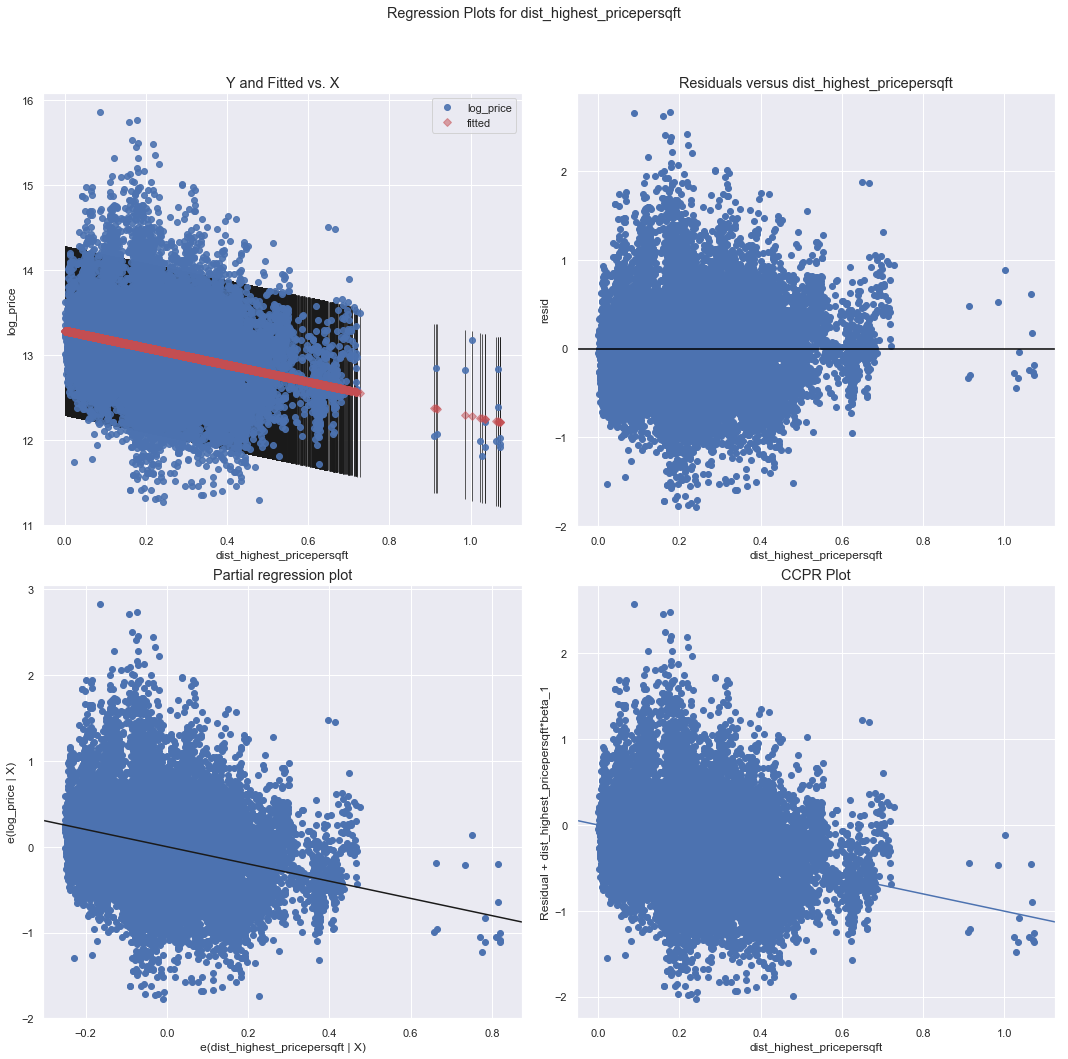

In [111]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(model_2, 'dist_highest_pricepersqft',fig=fig)
plt.show()

In [112]:
formula_yr_last_updated = 'log_price~yr_last_updated'
model_3 = ols(formula = formula_yr_last_updated, data = train_df).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     187.0
Date:                Wed, 23 Oct 2019   Prob (F-statistic):           2.42e-42
Time:                        09:33:26   Log-Likelihood:                -13422.
No. Observations:               17276   AIC:                         2.685e+04
Df Residuals:                   17274   BIC:                         2.686e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.1384      0.285     32.073      0.000       8.580       9.697
yr_last_updated     0.0020      0.000     13.674      0.000       0.002       0.002
==============================================================================
Omnibus:                      666.824   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              819.747
Skew:                           0.437   Prob(JB):                    9.87e-179
Kurtosis:                       3.613   Cond. No.                     1.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
# Originally we considered and tried below using the distance to the highest priced property (similar to our 
# experimentation with using the Space Needle). However, given the split in data sets, it's highly possible 
# that the highest priced property in either set will differ massively, so we will only be using distance 
# to highest priced per sqft property, since it takes into account size. 

formula_dist_highest_price_prop = 'log_price~dist_highest_price_prop'
model_4 = ols(formula = formula_dist_highest_price_prop, data = train_df).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1633.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:26   Log-Likelihood:                -12734.
No. Observations:               17276   AIC:                         2.547e+04
Df Residuals:                   17274   BIC:                         2.549e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  13.2867      0.007   1810.113      0.000      13.272      13.301
dist_highest_price_prop    -1.2608      0.031    -40.410      0.000      -1.322      -1.200
==============================================================================
Omnibus:                      646.554   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              836.384
Skew:                           0.409   Prob(JB):                    2.41e-182
Kurtosis:                       3.703   Cond. No.                         8.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
formula_sqft_living15 = 'log_price~sqft_living15'
model_5 = ols(formula = formula_sqft_living15, data = train_df).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                 1.155e+04
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:26   Log-Likelihood:                -9090.9
No. Observations:               17276   AIC:                         1.819e+04
Df Residuals:                   17274   BIC:                         1.820e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.0520      0.010   1248.389      0.000      12.033      12.071
sqft_living15     0.0005   4.63e-06    107.487      0.000       0.000       0.001
==============================================================================
Omnibus:                      204.000   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.975
Skew:                           0.235   Prob(JB):                     3.82e-49
Kurtosis:                       3.299   Cond. No.                     6.47e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id='multivariatemodel'></a>


In [115]:
# Based on the univariate models we've run so far, we started selecting variables to use in our multi-variable 
# model. We chose sqft_living, dist_highest_pricepersqft and yr_last_updated. 
# Although we'd previously elected to use the log of the price with respect to sqft_living, we decided to run 
# the model with normal price first to compare marginal improvements. 
analytic_df = pd.DataFrame({'sqft_living': train_df.sqft_living, 'dist_highest_pricepersqft':train_df.dist_highest_pricepersqft, 'yr_last_updated':train_df.yr_last_updated})

target_df = pd.DataFrame({'price':train_df.log_price})

In [116]:
analytic_df = sm.add_constant(analytic_df)
model_sm = sm.OLS(target_df, analytic_df)

results = model_sm.fit()

results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     9019.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:26   Log-Likelihood:                -5372.8
No. Observations:               17276   AIC:                         1.075e+04
Df Residuals:                   17272   BIC:                         1.078e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0262      0.207     58.151      0.000      11.621      12.432
sqft_living                   0.0004   2.97e-06    144.129      0.000       0.000       0.000
dist_highest_pricepersqft    -1.3372      0.019    -70.648      0.000      -1.374      -1.300
yr_last_updated               0.0002      0.000      2.212      0.027    2.69e-05       0.000
==============================================================================
Omnibus:                      220.331   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.197
Skew:                          -0.055   Prob(JB):                     1.86e-85
Kurtosis:                       3.728   Cond. No.                     2.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

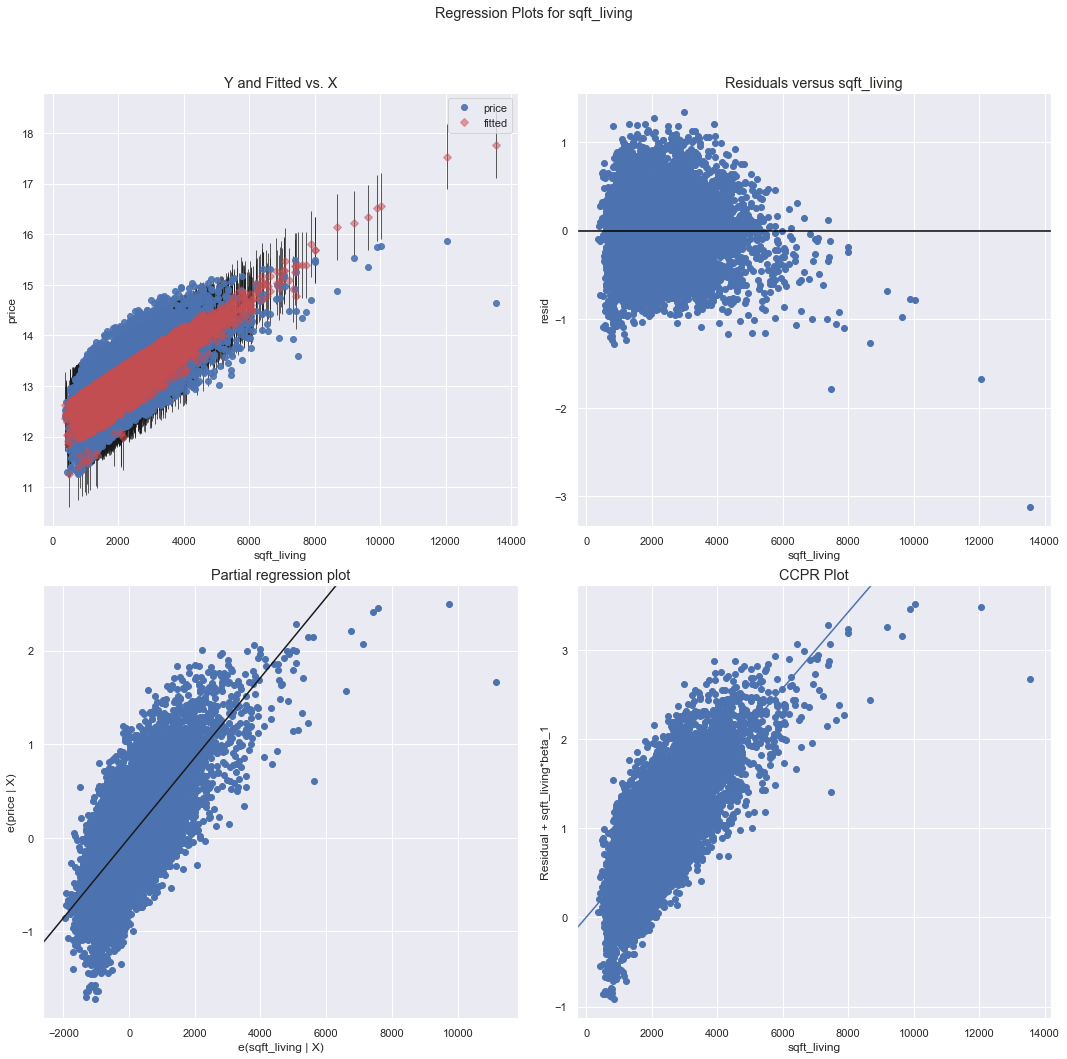

In [117]:
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(results, 'sqft_living',fig=fig)
plt.show()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


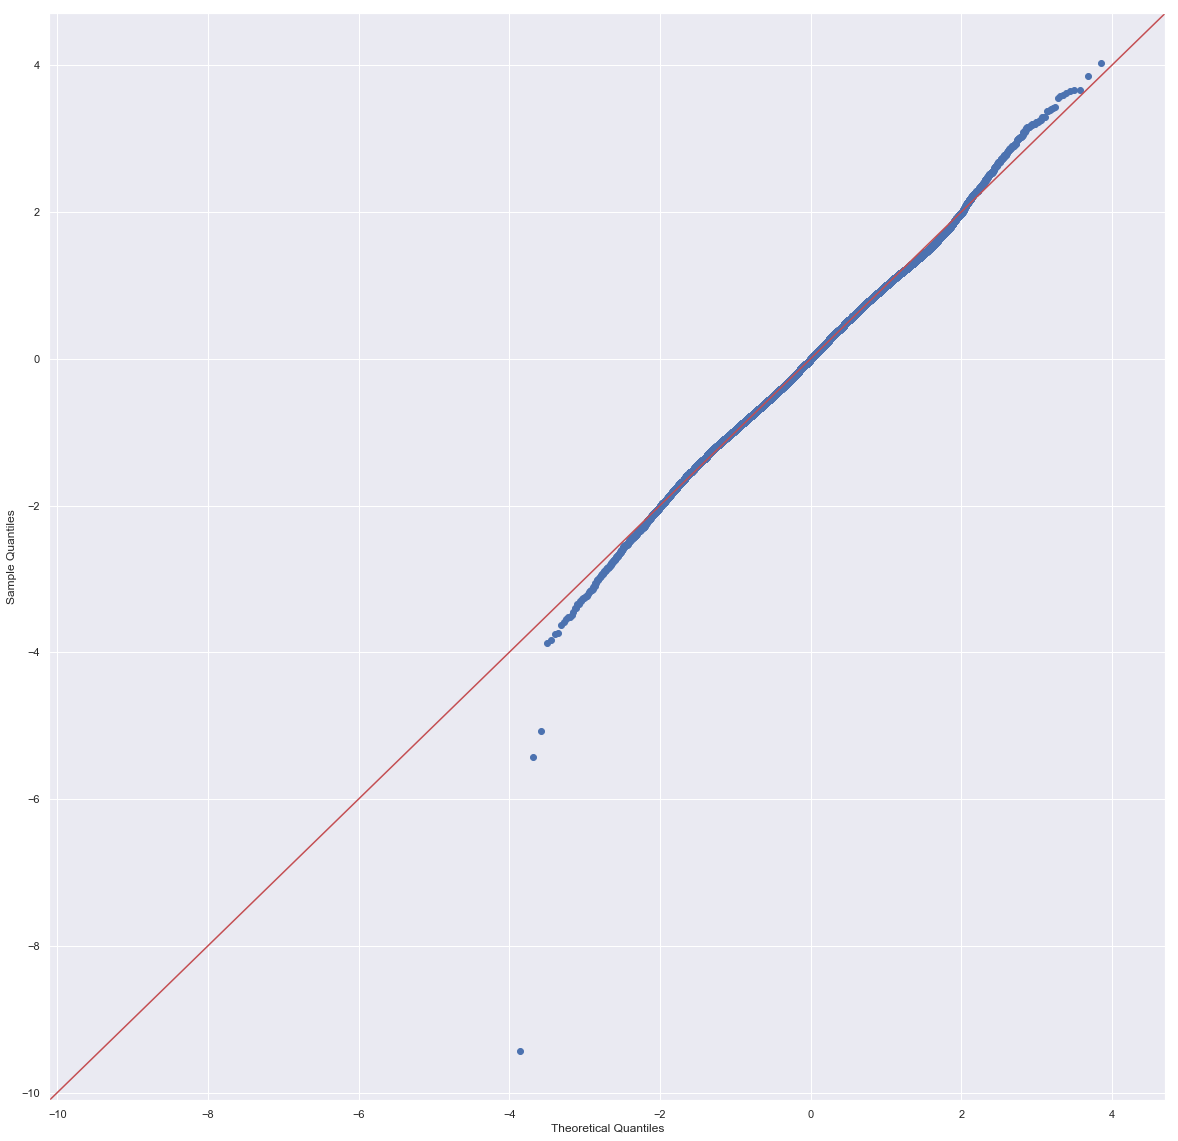

In [118]:
# 

residuals_multivariate_model = results.resid
fig = sm.graphics.qqplot(residuals_multivariate_model,dist=stats.norm, line='45', fit=True)
fig.show()

In [119]:
analytic_df = sm.add_constant(analytic_df)
model_sm = sm.OLS(target_df, analytic_df)

results = model_sm.fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     9019.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:29   Log-Likelihood:                -5372.8
No. Observations:               17276   AIC:                         1.075e+04
Df Residuals:                   17272   BIC:                         1.078e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.0262      0.207     58.151      0.000      11.621      12.432
sqft_living                   0.0004   2.97e-06    144.129      0.000       0.000       0.000
dist_highest_pricepersqft    -1.3372      0.019    -70.648      0.000      -1.374      -1.300
yr_last_updated               0.0002      0.000      2.212      0.027    2.69e-05       0.000
==============================================================================
Omnibus:                      220.331   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              390.197
Skew:                          -0.055   Prob(JB):                     1.86e-85
Kurtosis:                       3.728   Cond. No.                     2.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

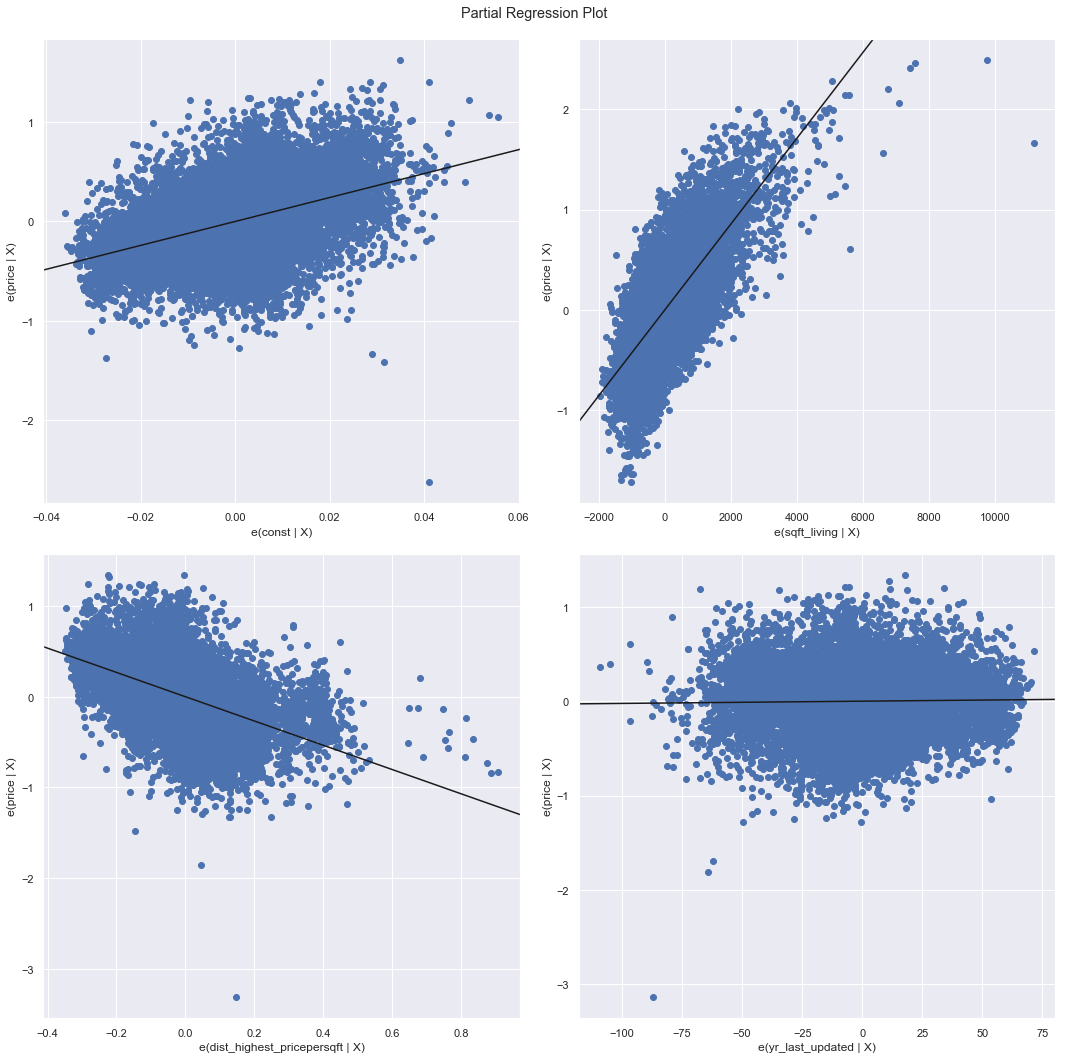

In [120]:
fig = plt.figure(figsize=(15,15))
# fig = sm.graphics.plot_regress_exog(results,'price',fig=fig)
fig = sm.graphics.plot_partregress_grid(results, fig=fig)
plt.show()

In [121]:
# We've decided to provide an additional model, using the log of sqft_living, because we reasoned that this would be 
# more useful to developers who are interested in how the change in square footage impacts on the change in price. 
# However, the p-value for yr_updated came at 0.186, forcing us to remove it from our developers model - see below.
analytic_df_2 = pd.DataFrame({'log_sqft_living': train_df.log_sqft_living, 'dist_highest_pricepersqft':train_df.dist_highest_pricepersqft, 'yr_last_updated':train_df.yr_last_updated})

target_df_2 = pd.DataFrame({'price':train_df.log_price})

In [122]:
analytic_df_2 = sm.add_constant(analytic_df_2)
model_sm_2 = sm.OLS(target_df_2, analytic_df_2)

results_2 = model_sm_2.fit()

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     8415.
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:30   Log-Likelihood:                -5733.1
No. Observations:               17276   AIC:                         1.147e+04
Df Residuals:                   17272   BIC:                         1.151e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         6.7701      0.203     33.363      0.000       6.372       7.168
log_sqft_living               0.9144      0.007    138.632      0.000       0.901       0.927
dist_highest_pricepersqft    -1.3563      0.019    -70.194      0.000      -1.394      -1.318
yr_last_updated              -0.0001      0.000     -1.324      0.186      -0.000    7.03e-05
==============================================================================
Omnibus:                       45.740   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.032
Skew:                           0.111   Prob(JB):                     6.13e-11
Kurtosis:                       3.126   Cond. No.                     1.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
analytic_df_2 = pd.DataFrame({'log_sqft_living': train_df.log_sqft_living, 'dist_highest_pricepersqft':train_df.dist_highest_pricepersqft})

target_df_2 = pd.DataFrame({'price':train_df.log_price})

In [124]:
analytic_df_2 = sm.add_constant(analytic_df_2)
model_sm_2 = sm.OLS(target_df_2, analytic_df_2)

results_2 = model_sm_2.fit()

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                 1.262e+04
Date:                Wed, 23 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:33:30   Log-Likelihood:                -5734.0
No. Observations:               17276   AIC:                         1.147e+04
Df Residuals:                   17273   BIC:                         1.150e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         6.5085      0.046    141.241      0.000       6.418       6.599
log_sqft_living               0.9112      0.006    147.999      0.000       0.899       0.923
dist_highest_pricepersqft    -1.3670      0.018    -77.939      0.000      -1.401      -1.333
==============================================================================
Omnibus:                       48.480   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.760
Skew:                           0.116   Prob(JB):                     1.57e-11
Kurtosis:                       3.124   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


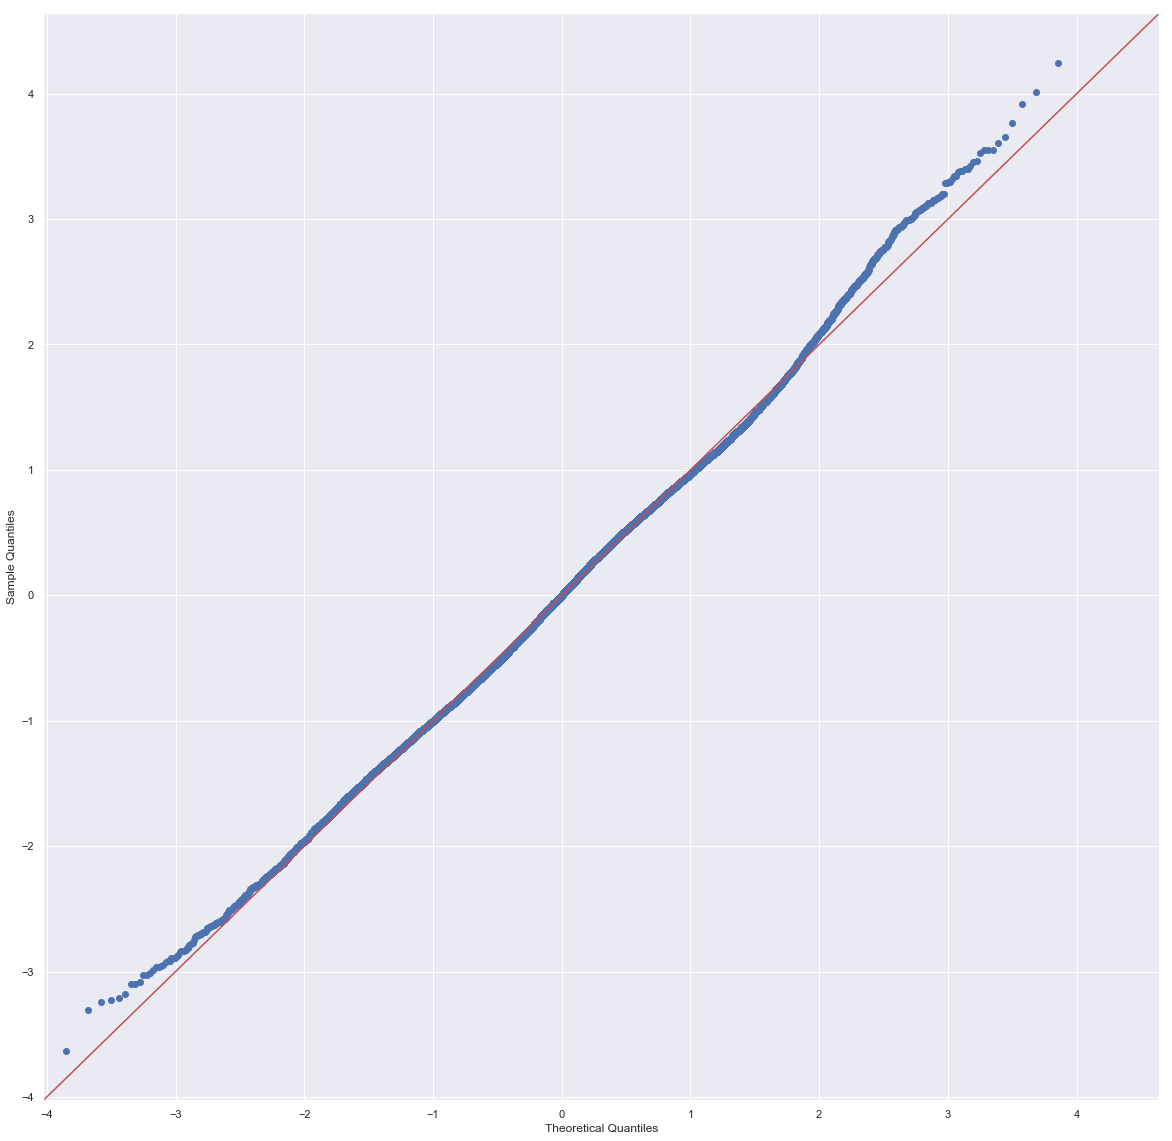

In [125]:
residuals_multivariate_model_2 = results_2.resid
fig = sm.graphics.qqplot(residuals_multivariate_model_2,dist=stats.norm, line='45', fit=True)
fig.show()

<a id='Testing-our-model'></a>

### 4.3 Testing our model


In [126]:
test_input_df = pd.DataFrame({'sqft_living': test_df.sqft_living, 'dist_highest_pricepersqft':test_df.dist_highest_pricepersqft, 'yr_last_updated':test_df.yr_last_updated})
print(analytic_df.head())
print(test_input_df.head())

test_input_df = sm.add_constant(test_input_df)
test_input_df.head()

   const  sqft_living  dist_highest_pricepersqft  yr_last_updated
0    1.0         1180                   0.221226           1955.0
1    1.0         2570                   0.074650           1991.0
2    1.0          770                   0.161218           1933.0
3    1.0         1960                   0.169506           1965.0
4    1.0         1680                   0.349788           1987.0
       sqft_living  dist_highest_pricepersqft  yr_last_updated
17276         2270                   0.147193           1967.0
17277         2270                   0.147193           1967.0
17278         1470                   0.414451           2005.0
17279         1280                   0.320331           1976.0
17280         2830                   0.320288           2005.0


const  sqft_living  dist_highest_pricepersqft  yr_last_updated
17276    1.0         2270                   0.147193           1967.0
17277    1.0         2270                   0.147193           1967.0
17278    1.0         1470                   0.414451           2005.0
17279    1.0         1280                   0.320331           1976.0
17280    1.0         2830                   0.320288           2005.0

In [127]:
log_price_pred = results.predict(test_input_df)


In [128]:
eval_results = pd.DataFrame({'actual_log_price':test_df.log_price, 'pred_log_price':log_price_pred, 'error':abs(test_df.log_price - log_price_pred)})

In [129]:
eval_results.head()

actual_log_price  pred_log_price     error
17276         12.847927       13.265927  0.418001
17277         13.345347       13.265927  0.079420
17278         12.847321       12.575326  0.271995
17279         12.736701       12.613045  0.123656
17280         13.152893       13.283006  0.130113

In [130]:
eval_results.describe()

actual_log_price  pred_log_price        error
count       4321.000000     4321.000000  4321.000000
mean          13.104645       13.093593     0.244508
std            0.512552        0.419085     0.185173
min           11.326596       11.690549     0.000230
25%           12.751300       12.814923     0.105758
50%           13.071070       13.031974     0.209871
75%           13.415033       13.310939     0.339736
max           15.150512       15.645168     1.423324

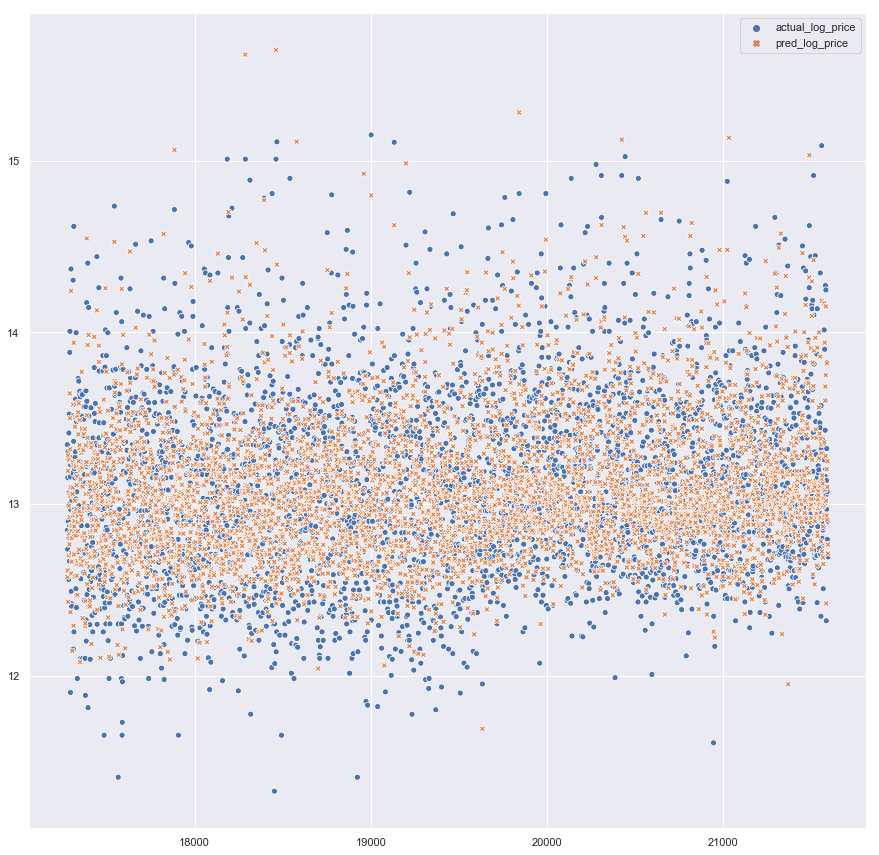

In [131]:
fig = plt.figure(figsize=(15,15))

sns.scatterplot(data=eval_results.drop(columns='error'))
plt.show()

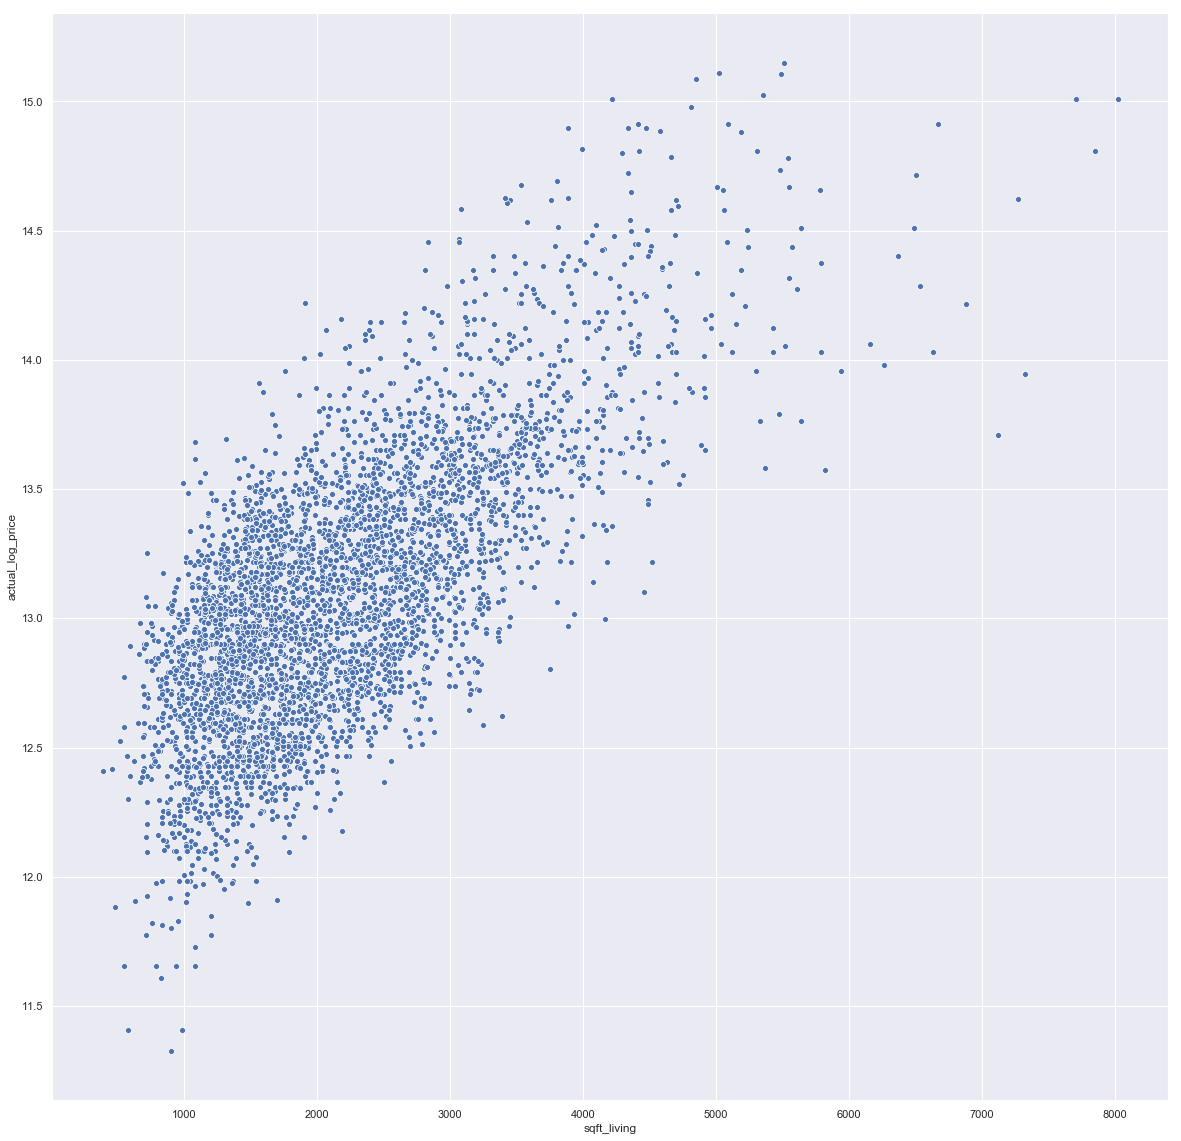

In [132]:
sns.scatterplot(y=eval_results.actual_log_price,x=test_df.sqft_living)
plt.plot(y=eval_results.pred_log_price,x=test_df.sqft_living,color='r',linewidth = 1)
plt.show()

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


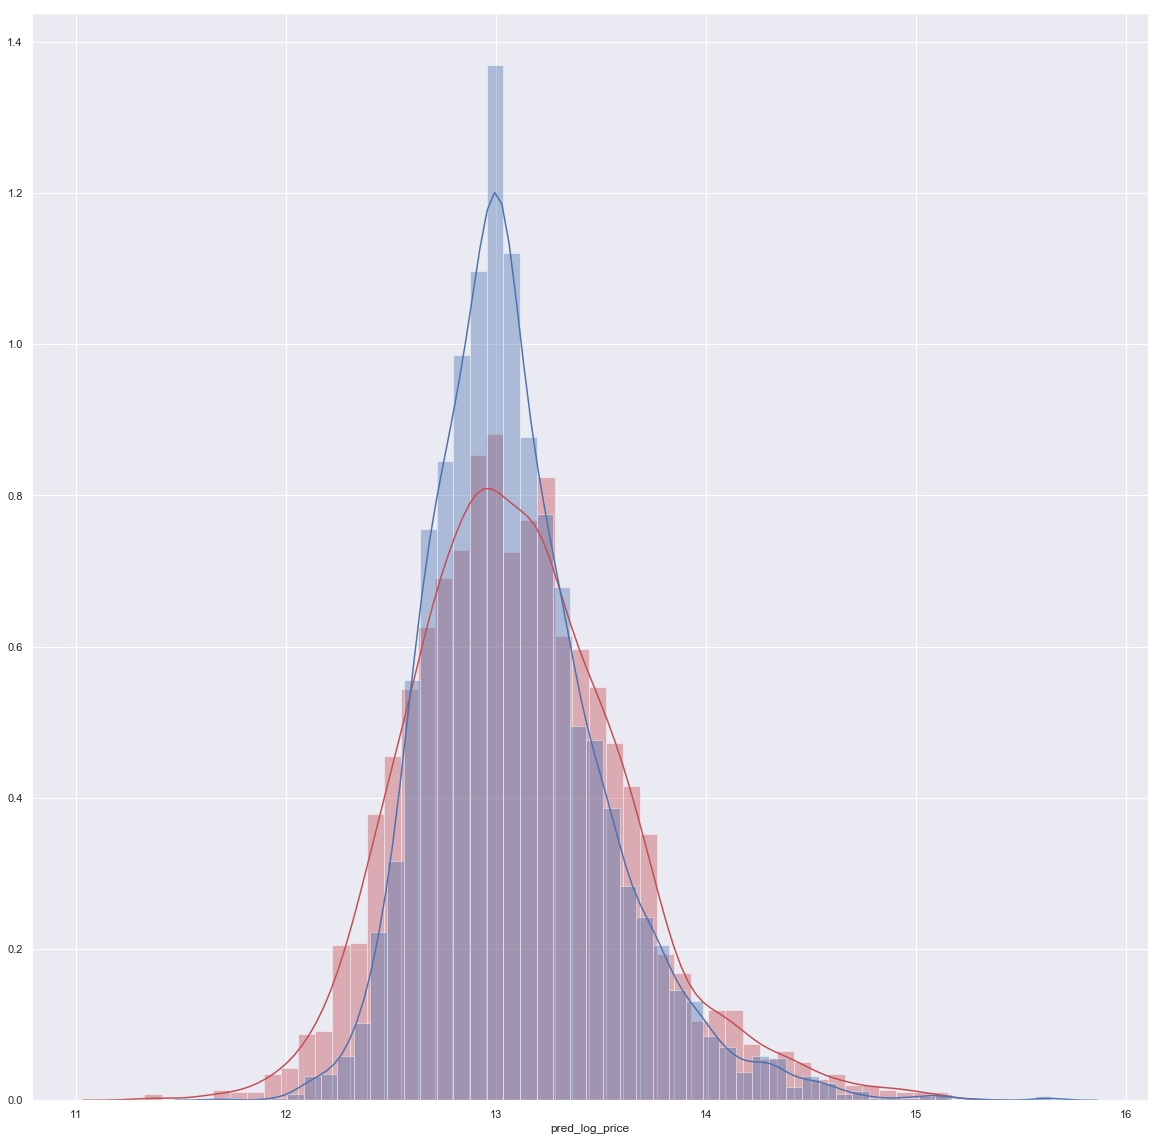

In [133]:
sns.distplot(eval_results.actual_log_price, color='r')
sns.distplot(eval_results.pred_log_price, color='b')

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


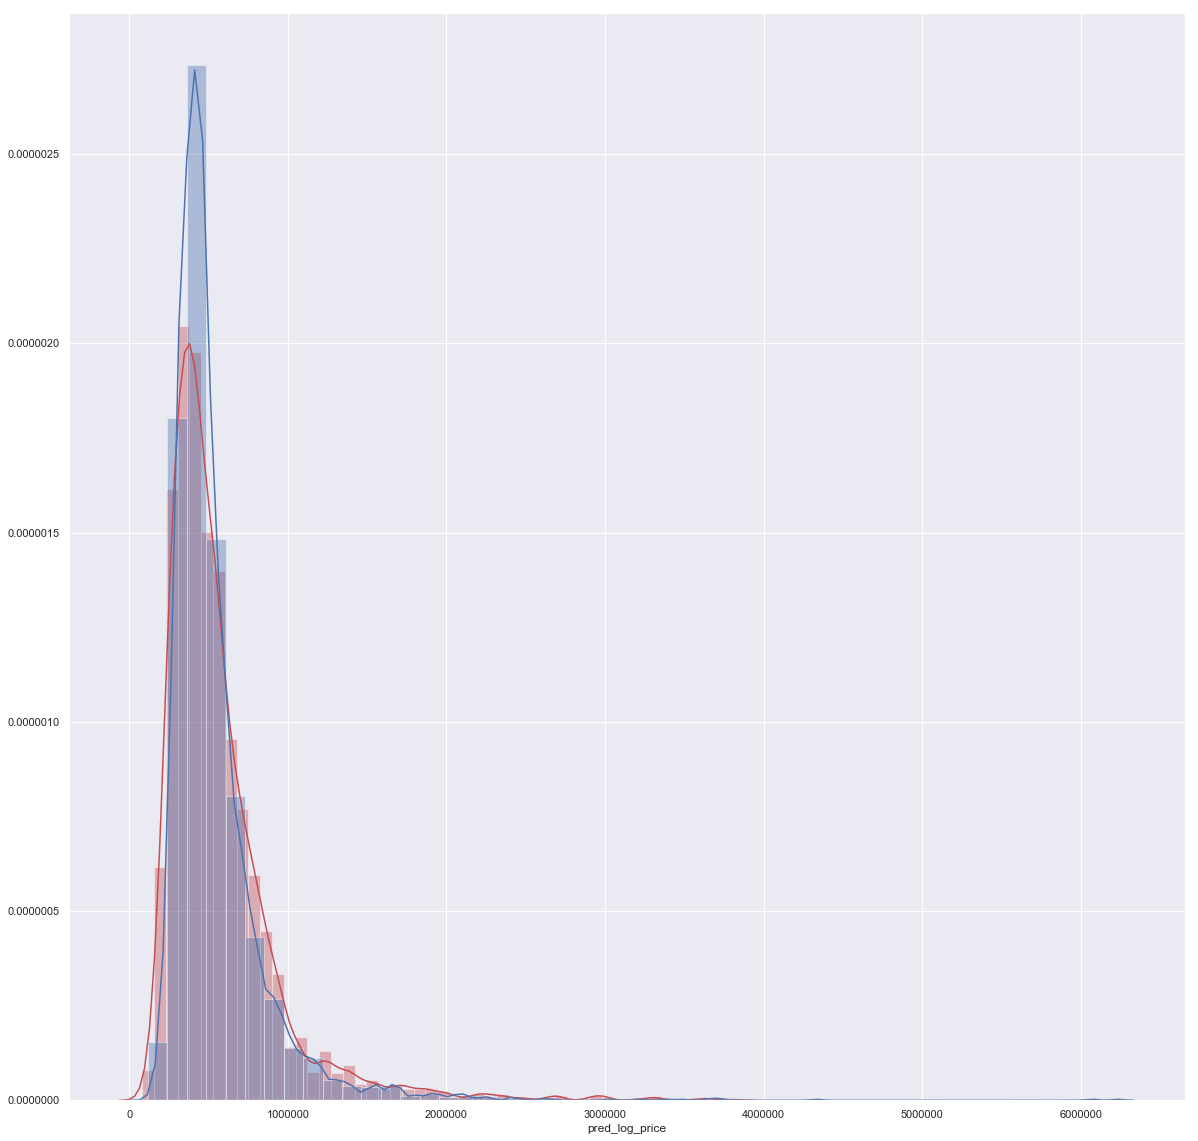

In [134]:
sns.distplot(np.exp(eval_results.actual_log_price), color='r')
sns.distplot(np.exp(eval_results.pred_log_price), color='b')

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


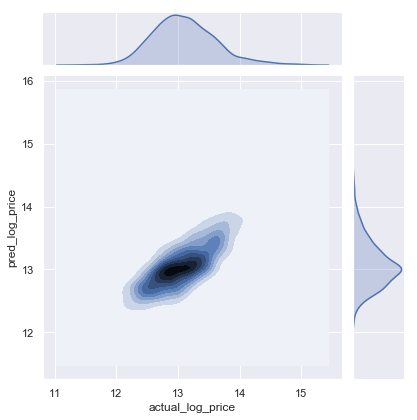

In [135]:
sns.jointplot(eval_results.actual_log_price,eval_results.pred_log_price,kind='kde')

<a id=heatmap></a>

Visualizations: for the purposes of our exploration we've chosen the location within KC as a relatively good predictor of price. To support our argument, we've built a heatmap of the price over the map, using folium. 

In [141]:
mapping_df = pd.DataFrame({'price':train_df['price'], 'latitude':train_df['lat'], 'longitude':train_df['long'], 'price_persqft':train_df['price_per_sqft']})
print(len(mapping_df))
def generate_base_map(default_location = [mapping_df.latitude.median(),mapping_df.longitude.median()],default_zoom_start=10):
    base_map = folium.Map(location = default_location, control_scale=False, zoom_start = default_zoom_start)
    return base_map

base_map = generate_base_map(default_zoom_start=10)

map_gradient = {0.45: 'blue', 0.6: 'lime', 0.9: 'red'}


from folium.plugins import HeatMap
HeatMap(data = mapping_df[['latitude','longitude','price']],radius = 7, gradient = map_gradient).add_to(base_map)

17276


In [142]:
# 
base_map

In [139]:
next_map = generate_base_map()
map_gradient_2 = {0.45: 'blue', 0.6: 'lime', 0.9: 'red'}

HeatMap(data = mapping_df[['latitude','longitude','price_persqft']],radius = 7, max_zoom = 10, gradient = map_gradient_2).add_to(next_map)

In [145]:
next_map

<a id='Conclusion'></a>

## 5. Conclusion


    1. Is the amount of square foot of living space an effective predictor of house price and if so, by how much?
   [Model with only sqft_living](#univariatesqft_living); 
   [Multivariate model](#multivariatemodel)
   
    Square footage of living space was found to be the most impactful predictor of the logarithm of sale price (R^2 = 0.476), and its residuals were generally scale-independent, except at the very top end of the price scale. NB: our multivariate model relied heavily on this as a variable (R^2 of entire model = 0.61). 
    
    2. Assuming that houses that have not been rennovated were last modified in the year that they were built, is there a correlation between the year that houses were last modified and their price? 
    The correlation between the year of last modifications and the logarithm of price was very weak and in some cases made our model weaker. Renovation did increase house sale price on average, however, even discounting the unrenovated houses, renovation was a very poor predictor of house price. 
    
    3. If we plot the location of houses in KC across the county map, are there any particular geographical areas that have a strong correlation with price? (see heatmap in section 4.3)
[heatmap](#heatmap)

    There was a mild correlation between the distance from the property with the highest price per square foot. There are pockets of higher prices distributed across the county, which can be used as an additional predictor of your price band when setting your sale value. 
    


##### Sub questions:    
     - what is the level of spending on square footage (during building or rennovation) that will typically lead to a profit when selling the house)?
      The average level of spending per sqft is shown just below. Generally developers should aim to keep their build cost below this level in order to profit from a sale. 

In [150]:
clean_df.price_per_sqft.mean().round(2)

264.14

- If building houses at the same cost, will location be a factor?
Generally yes, as indicated in the heatmap in section 4. 
- Is this a good indication for maximising profits for a development company?
Without more data (e.g. on labor and material costs) we are unable to tell if this maximizes profit for a development company.